# Assignment 2: Stochastic and Spatial Models

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
import pandas as pd
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
from scipy import stats

%matplotlib inline
plt.style.use('default')

## Stochastic Models

### Implement Gillispie's algorithm & Investigate Simulation Variability and Negative Co-variance

In [ ]:
# Function to run a single Gillespie simulation
def gillespie_SIR(beta, gamma, N, S0, I0, R0, t_max):
    '''
    This function exectutes Gillespie's algorithm. 
    Args:
        beta: 
        gamma:
        N: 
        S0: 
        I0: 
        
    '''
    S = S0
    I = I0
    R = R0
    t = 0

    times = [t]
    S_vals = [S]
    I_vals = [I]
    R_vals = [R]

    while t < t_max and I > 0:
        # Calculate rates
        a1 = beta * S * I / N     # Infection rate
        a2 = gamma * I            # Recovery rate
        a0 = a1 + a2              # Total rate

        if a0 == 0:
            break

        # Time to next event
        r1 = np.random.uniform()
        delta_t = -np.log(r1) / a0
        t += delta_t

        # Determine event
        r2 = np.random.uniform()
        if r2 < a1 / a0:
            # Infection event
            S -= 1
            I += 1
        else:
            # Recovery event
            I -= 1
            R += 1

        # Store results
        times.append(t)
        S_vals.append(S)
        I_vals.append(I)
        R_vals.append(R)

    return np.array(times), np.array(S_vals), np.array(I_vals), np.array(R_vals)

# Function for deterministic SIR model
def SIR_ode(y, t, beta, gamma, N):
    S, I, R = y
    dSdt = -beta * S * I / N
    dIdt = beta * S * I / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

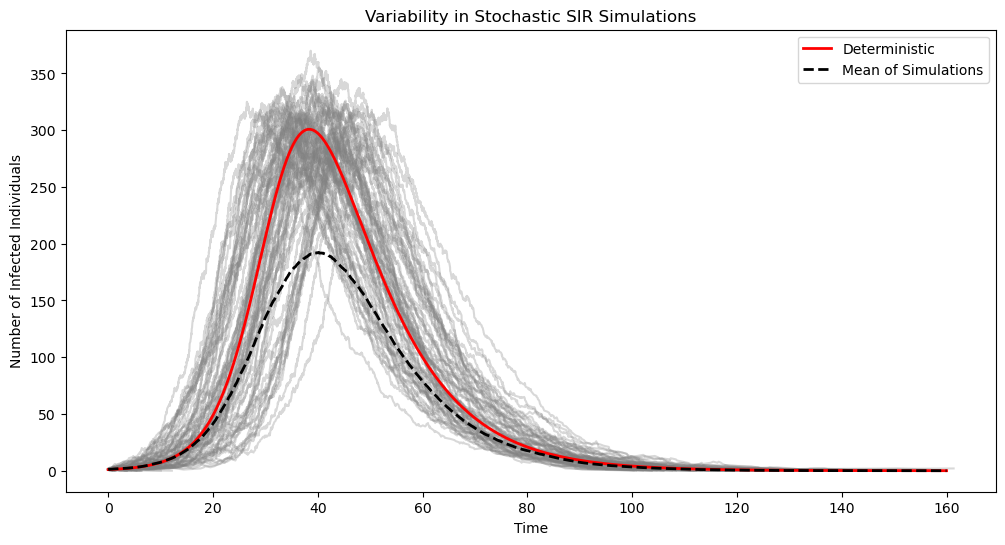

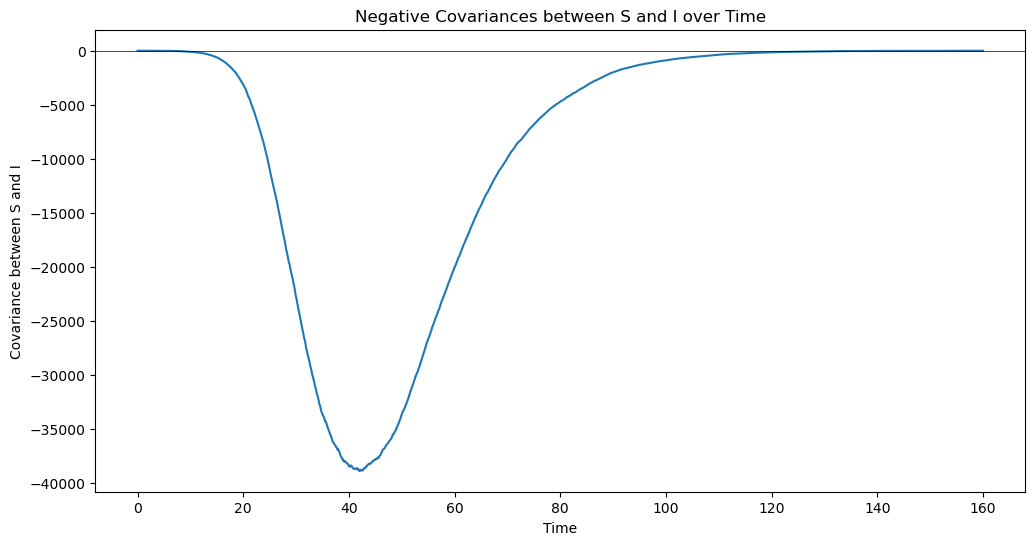

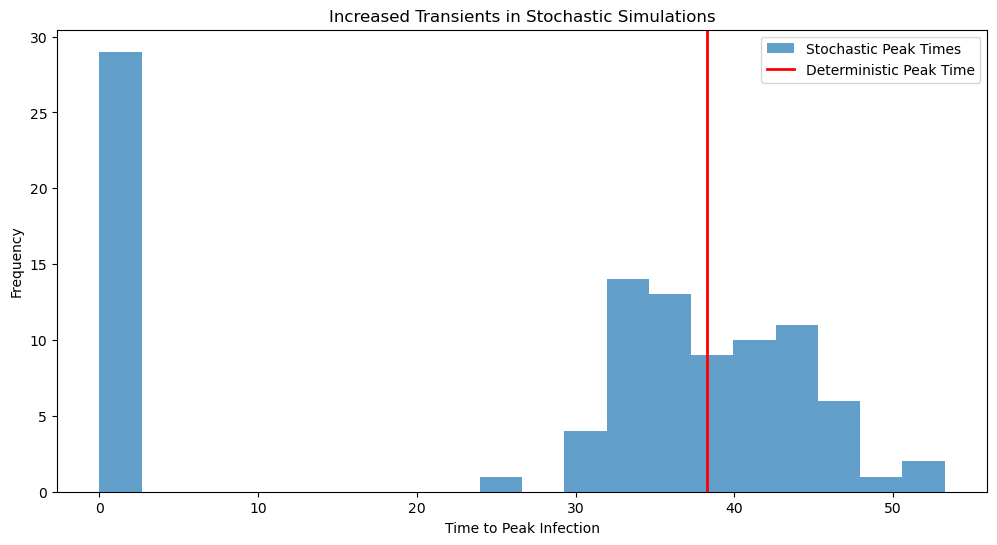

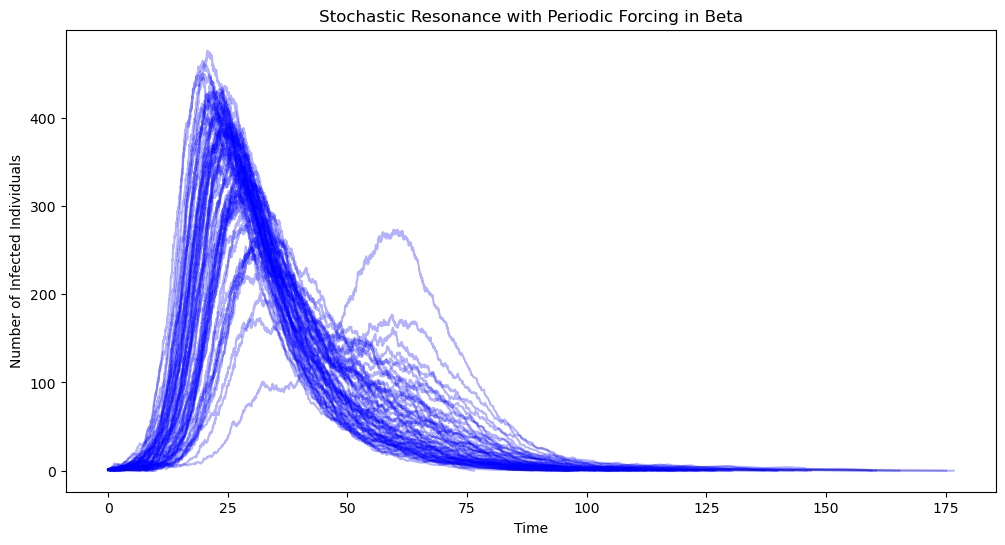

Number of extinctions out of 100 simulations: 99


In [2]:
# Parameters
beta = 0.3      # Transmission rate
gamma = 0.1     # Recovery rate
N = 1000        # Total population
num_simulations = 100  # Number of stochastic simulations
t_max = 160     # Maximum time

# Time points for deterministic solution
t_det = np.linspace(0, t_max, 1000)

# Initial conditions
S0 = N - 1
I0 = 1
R0 = 0

# Solve deterministic SIR model
y0 = [S0, I0, R0]
ret = odeint(SIR_ode, y0, t_det, args=(beta, gamma, N))
S_det, I_det, R_det = ret.T

# Lists to store multiple simulation results
S_values = []
I_values = []
R_values = []
time_values = []

# Run multiple Gillespie simulations
for sim in range(num_simulations):
    times, S_vals, I_vals, R_vals = gillespie_SIR(beta, gamma, N, S0, I0, R0, t_max)
    I_values.append(I_vals)
    S_values.append(S_vals)
    R_values.append(R_vals)
    time_values.append(times)

# Align data for statistical analysis
max_len = max(len(tv) for tv in time_values)
time_grid = np.linspace(0, t_max, max_len)

I_interp = np.zeros((num_simulations, max_len))
S_interp = np.zeros((num_simulations, max_len))
R_interp = np.zeros((num_simulations, max_len))

for i in range(num_simulations):
    I_interp[i, :] = np.interp(time_grid, time_values[i], I_values[i])
    S_interp[i, :] = np.interp(time_grid, time_values[i], S_values[i])
    R_interp[i, :] = np.interp(time_grid, time_values[i], R_values[i])

# Compute statistics
I_mean = np.mean(I_interp, axis=0)
I_var = np.var(I_interp, axis=0)
S_mean = np.mean(S_interp, axis=0)
S_var = np.var(S_interp, axis=0)
cov_SI = np.mean((S_interp - S_mean) * (I_interp - I_mean), axis=0)


In [ ]:
# Plotting results

# 1. Variability: Plot multiple stochastic simulations and compare with deterministic solution
plt.figure(figsize=(12, 6))
for i in range(num_simulations):
    plt.plot(time_values[i], I_values[i], color='grey', alpha=0.3)
plt.plot(t_det, I_det, 'r', lw=2, label='Deterministic')
plt.plot(time_grid, I_mean, 'k--', lw=2, label='Mean of Simulations')
plt.xlabel('Time')
plt.ylabel('Number of Infected Individuals')
plt.title('Variability in Stochastic SIR Simulations')
plt.legend()
plt.show()

# 2. Negative Covariances: Plot covariance between S and I over time
plt.figure(figsize=(12, 6))
plt.plot(time_grid, cov_SI)
plt.xlabel('Time')
plt.ylabel('Covariance between S and I')
plt.title('Negative Covariances between S and I over Time')
plt.axhline(0, color='black', lw=0.5)
plt.show()

### Stochastic Resonance and Increased Transients

In [ ]:
# 3. Increased Transients: Compare the time to reach peak infection
peak_time_det = t_det[np.argmax(I_det)]
peak_times_stoch = [time_values[i][np.argmax(I_values[i])] for i in range(num_simulations)]

plt.figure(figsize=(12, 6))
plt.hist(peak_times_stoch, bins=20, alpha=0.7, label='Stochastic Peak Times')
plt.axvline(peak_time_det, color='red', lw=2, label='Deterministic Peak Time')
plt.xlabel('Time to Peak Infection')
plt.ylabel('Frequency')
plt.title('Increased Transients in Stochastic Simulations')
plt.legend()
plt.show()

### Extinction events and Critical Community Size

In [ ]:
# 4. Stochastic Resonance: Introduce periodic forcing in beta
def beta_time(t, beta0, amplitude, frequency):
    return beta0 * (1 + amplitude * np.sin(2 * np.pi * frequency * t))

# Modify the Gillespie function to accept time-dependent beta
def gillespie_SIR_forced(beta_func, gamma, N, S0, I0, R0, t_max):
    S = S0
    I = I0
    R = R0
    t = 0

    times = [t]
    S_vals = [S]
    I_vals = [I]
    R_vals = [R]

    while t < t_max and I > 0:
        current_beta = beta_func(t)
        a1 = current_beta * S * I / N
        a2 = gamma * I
        a0 = a1 + a2

        if a0 == 0:
            break

        r1 = np.random.uniform()
        delta_t = -np.log(r1) / a0
        t += delta_t

        r2 = np.random.uniform()
        if r2 < a1 / a0:
            S -= 1
            I += 1
        else:
            I -= 1
            R += 1

        times.append(t)
        S_vals.append(S)
        I_vals.append(I)
        R_vals.append(R)

    return np.array(times), np.array(S_vals), np.array(I_vals), np.array(R_vals)

In [ ]:
# Parameters for periodic forcing
amplitude = 0.5
frequency = 1/50  # One oscillation every 50 time units

# Run multiple simulations with periodic forcing
I_values_forced = []
time_values_forced = []

for sim in range(num_simulations):
    times_f, _, I_vals_f, _ = gillespie_SIR_forced(
        lambda t: beta_time(t, beta, amplitude, frequency), gamma, N, S0, I0, R0, t_max)
    I_values_forced.append(I_vals_f)
    time_values_forced.append(times_f)

# Plotting the effect of stochastic resonance
plt.figure(figsize=(12, 6))
for i in range(num_simulations):
    plt.plot(time_values_forced[i], I_values_forced[i], color='blue', alpha=0.3)
plt.xlabel('Time')
plt.ylabel('Number of Infected Individuals')
plt.title('Stochastic Resonance with Periodic Forcing in Beta')
plt.show()

# 5. Extinctions: Count the number of simulations where the disease goes extinct
extinctions = sum(1 for I_vals in I_values if I_vals[-1] == 0)
print(f'Number of extinctions out of {num_simulations} simulations: {extinctions}')

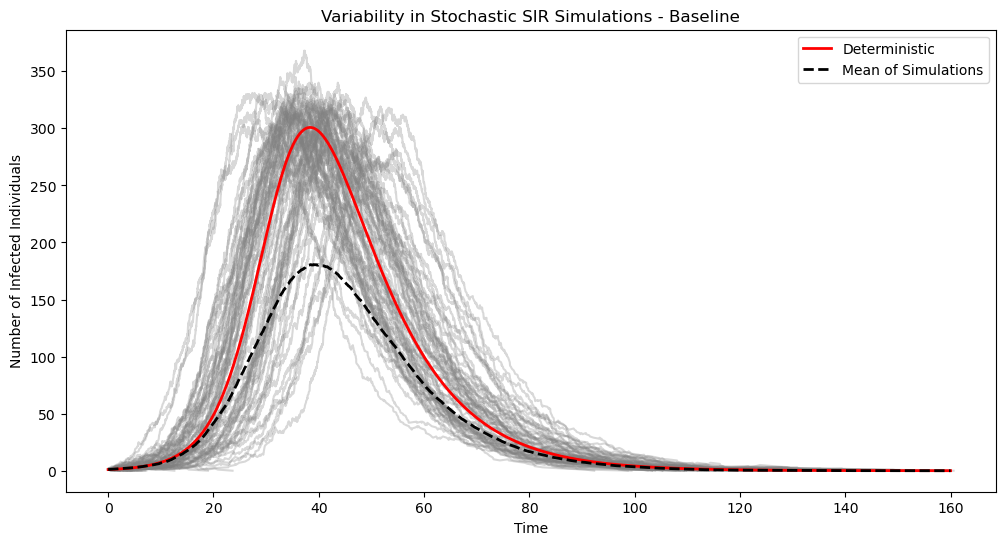

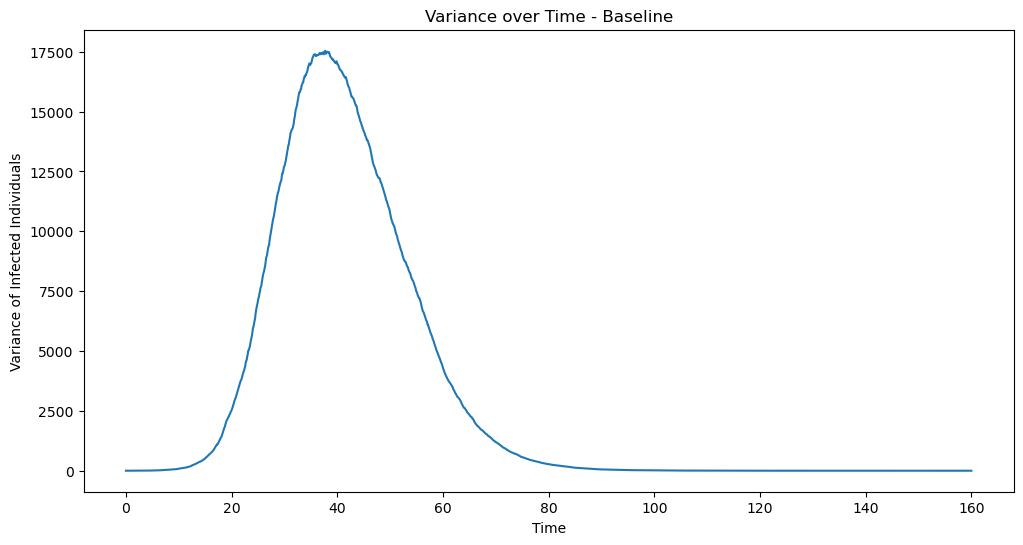

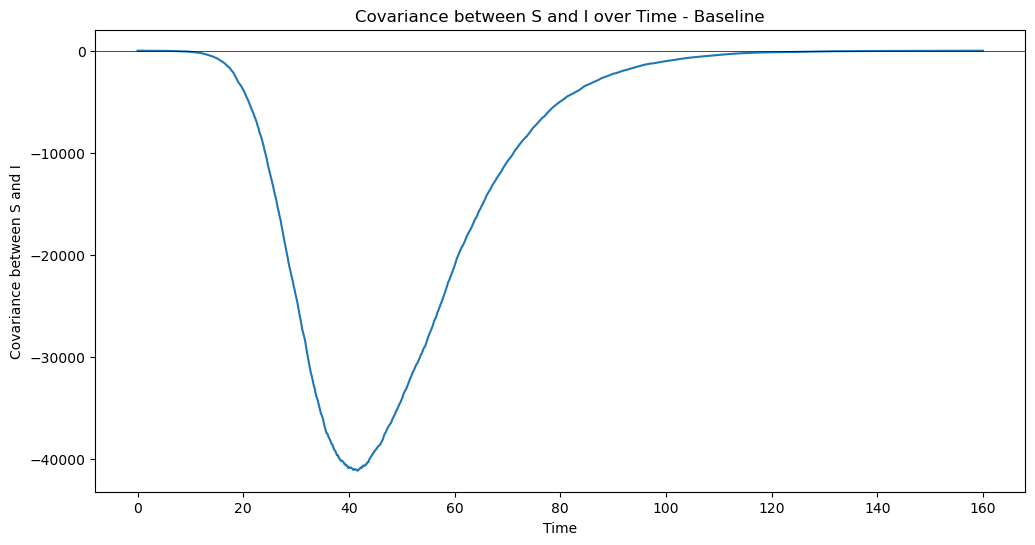

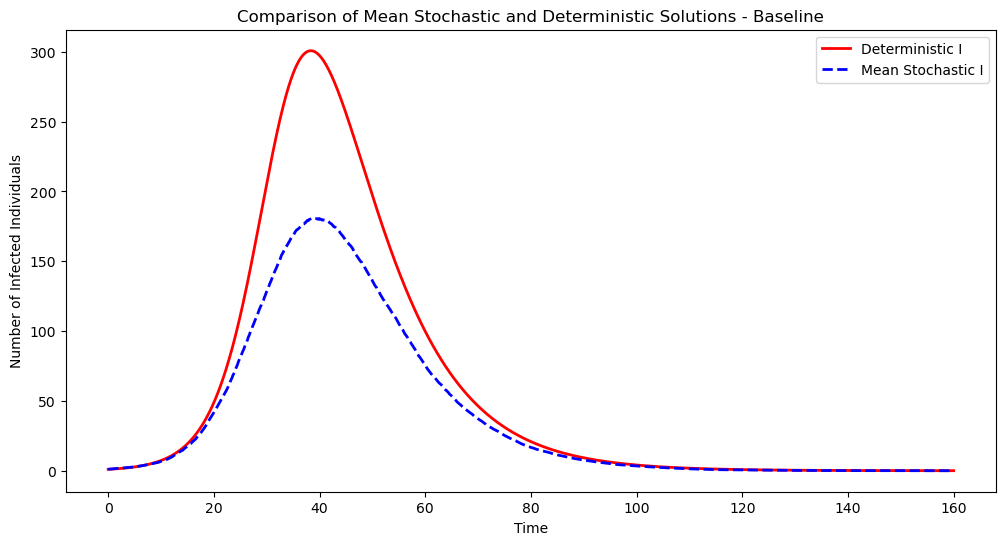

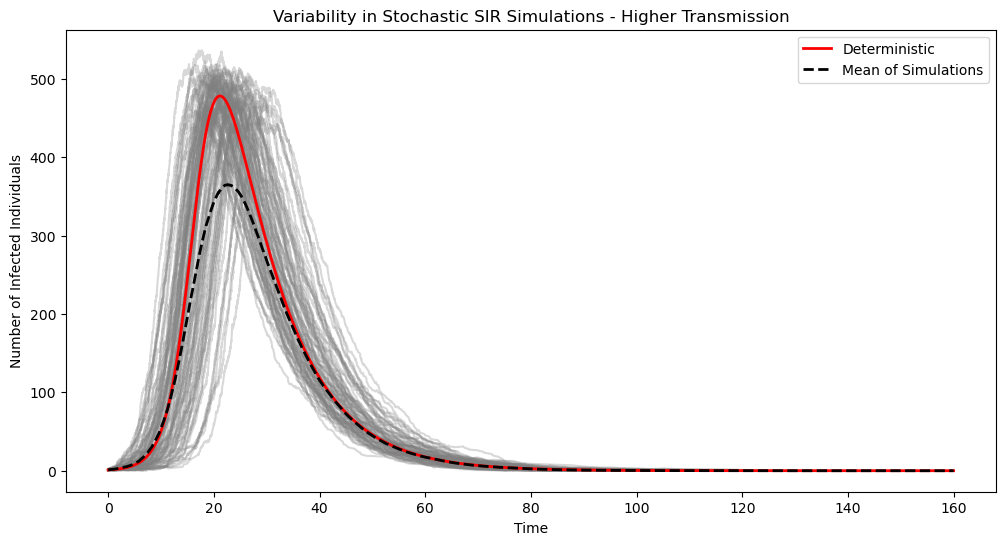

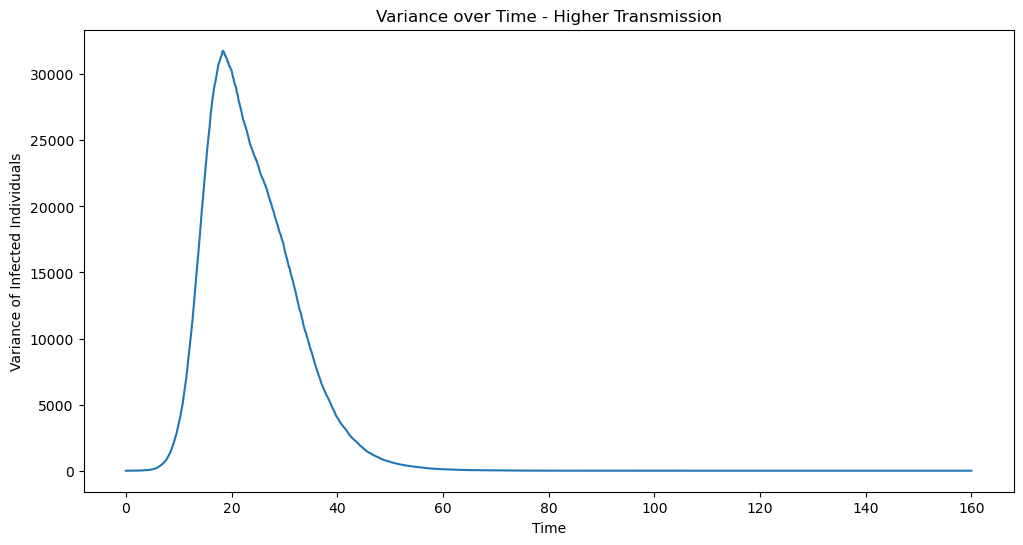

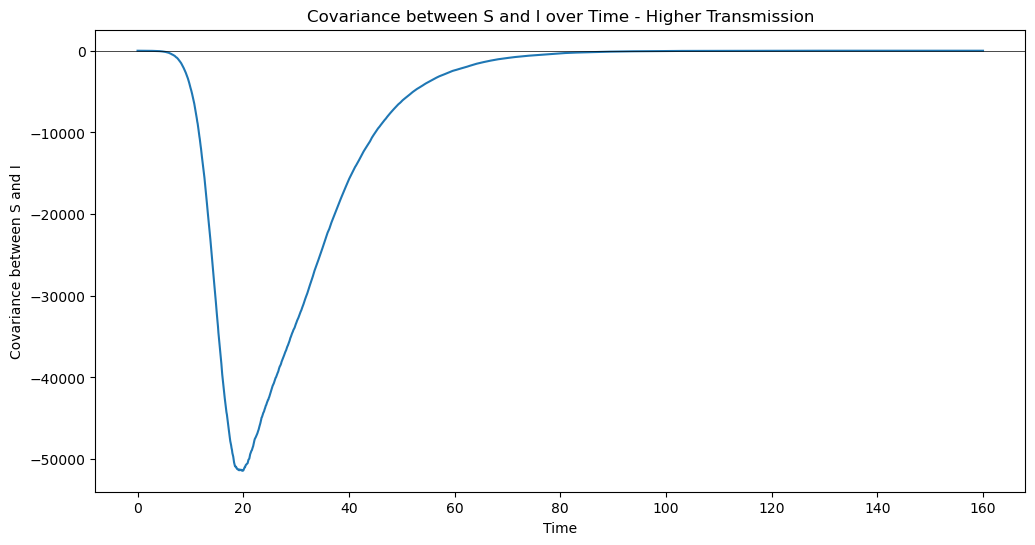

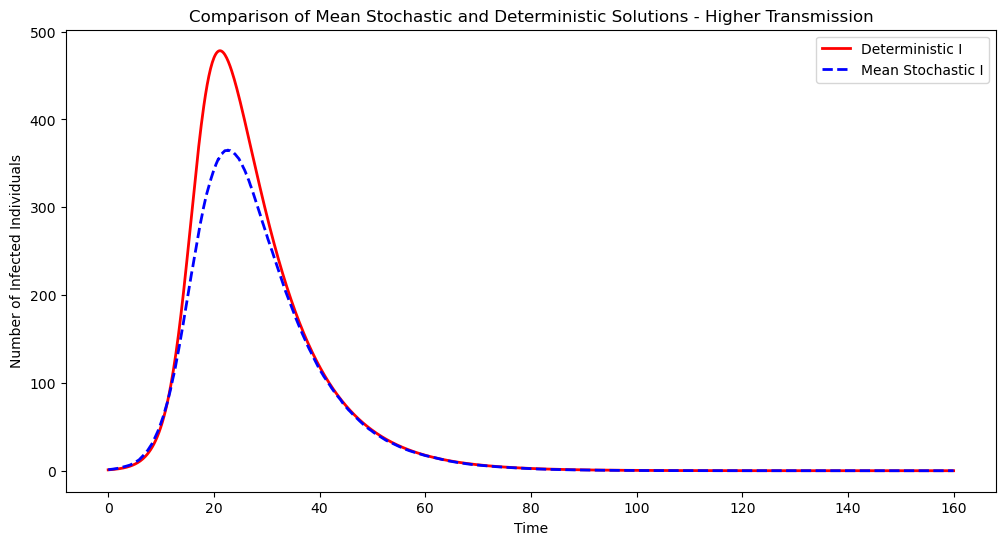

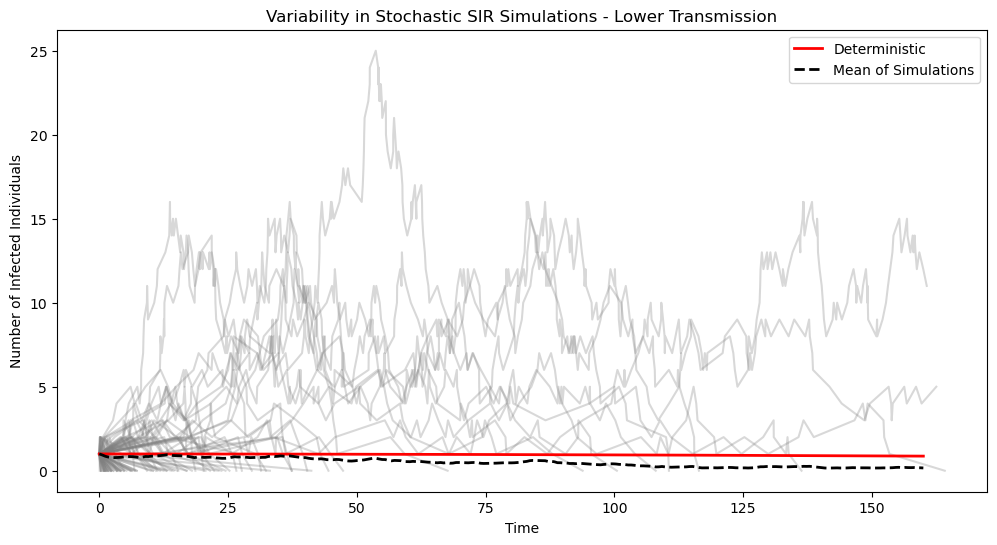

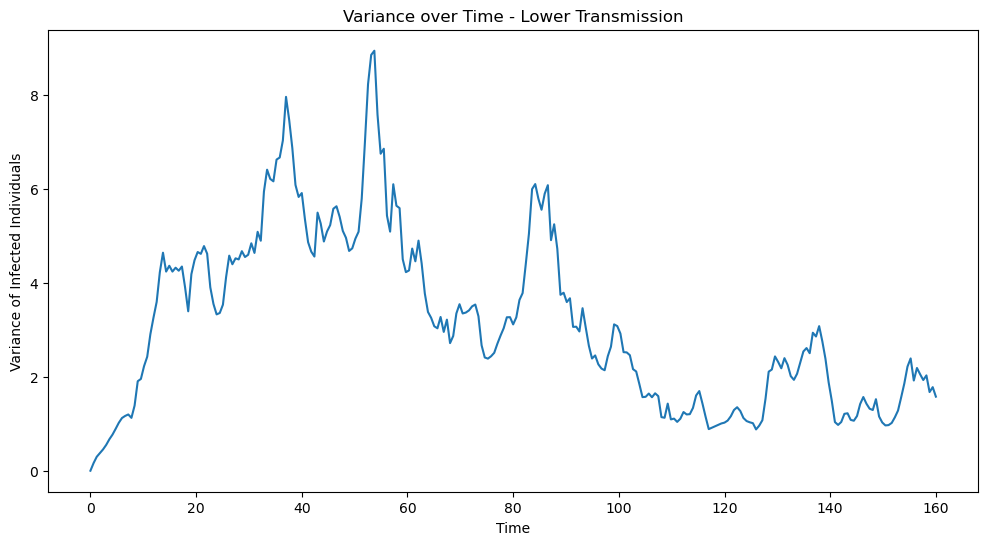

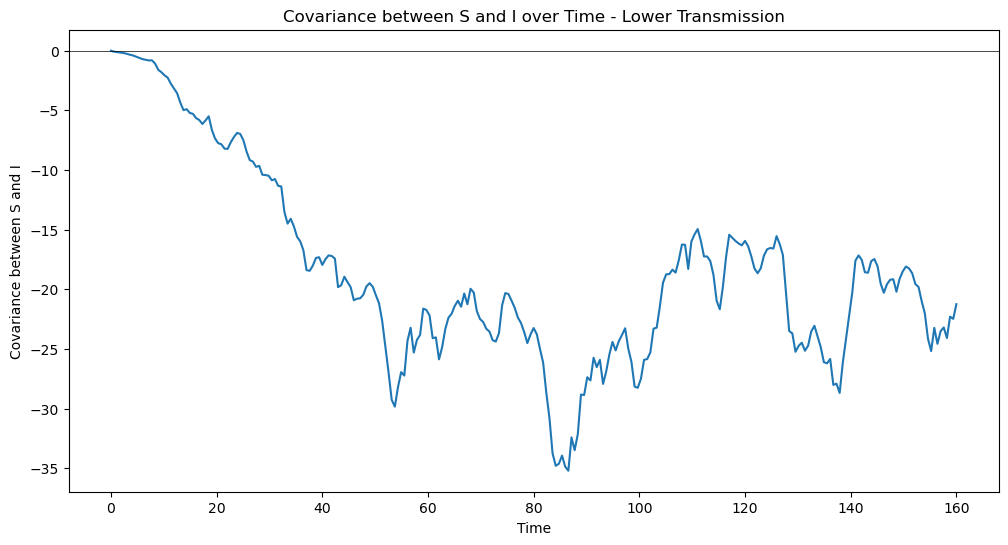

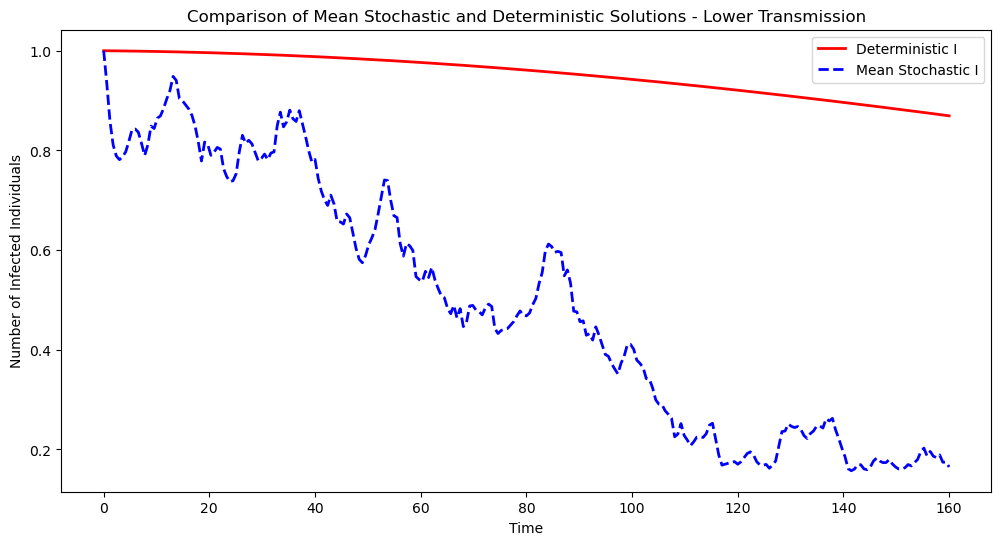

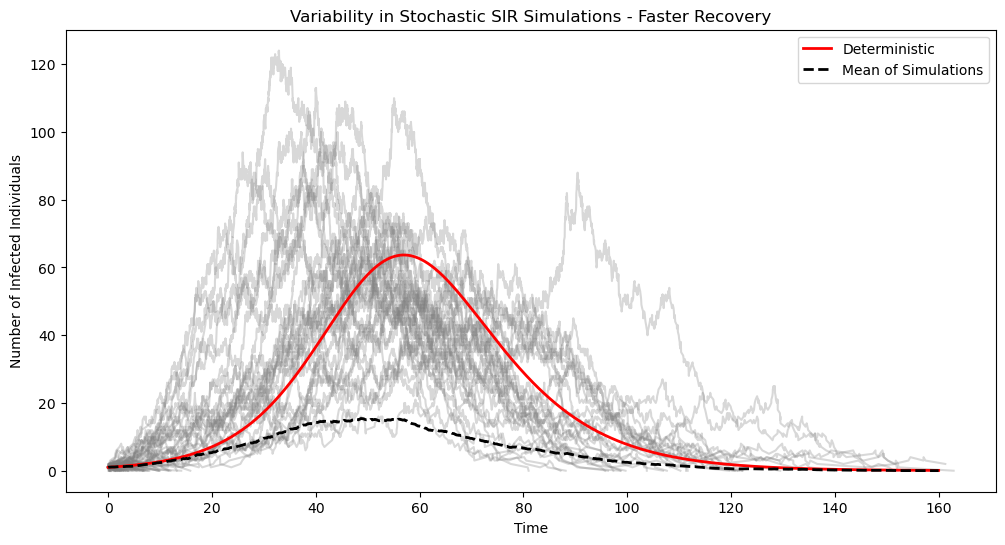

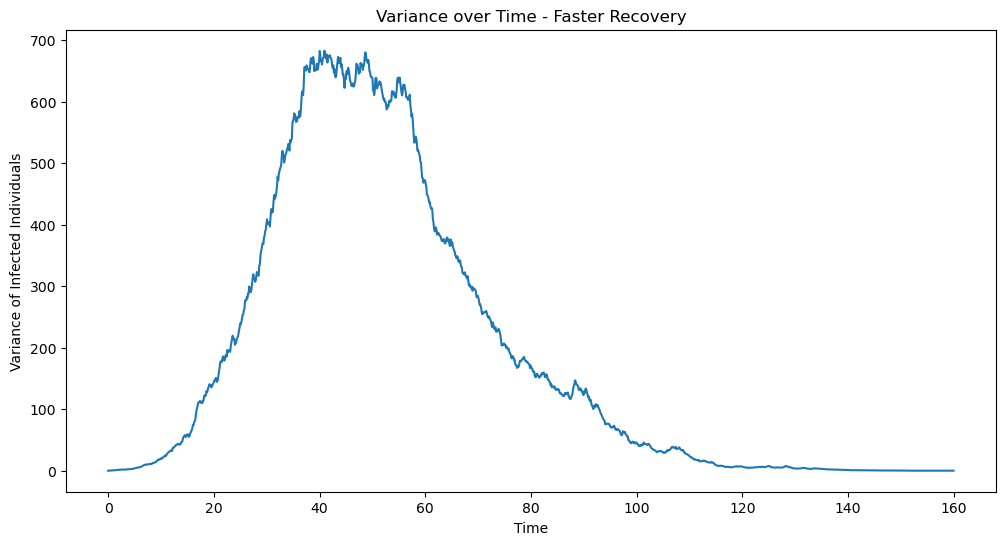

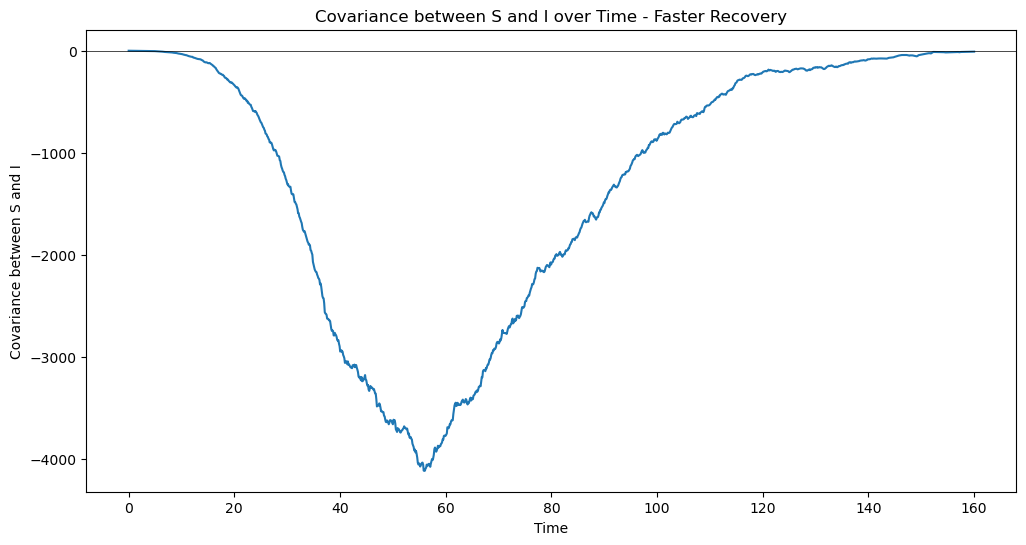

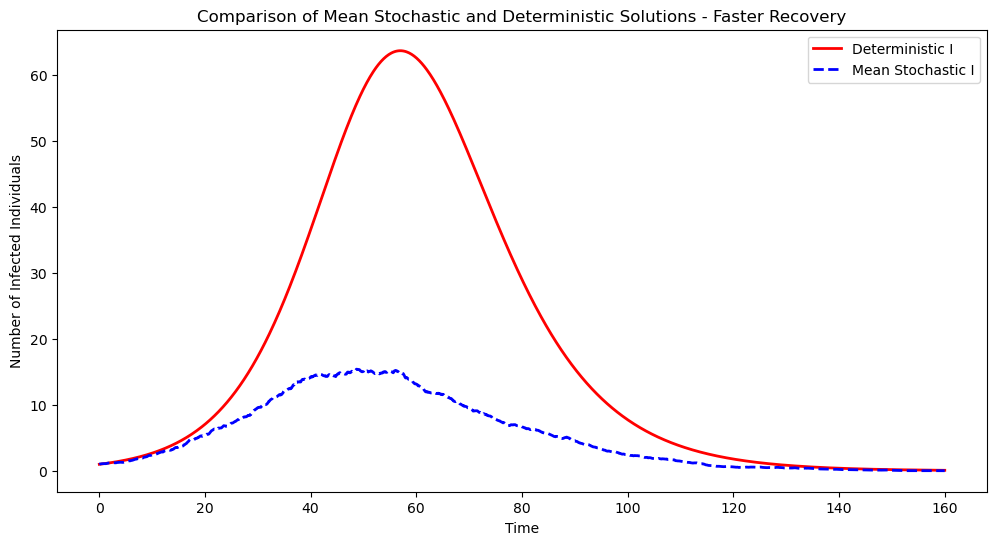

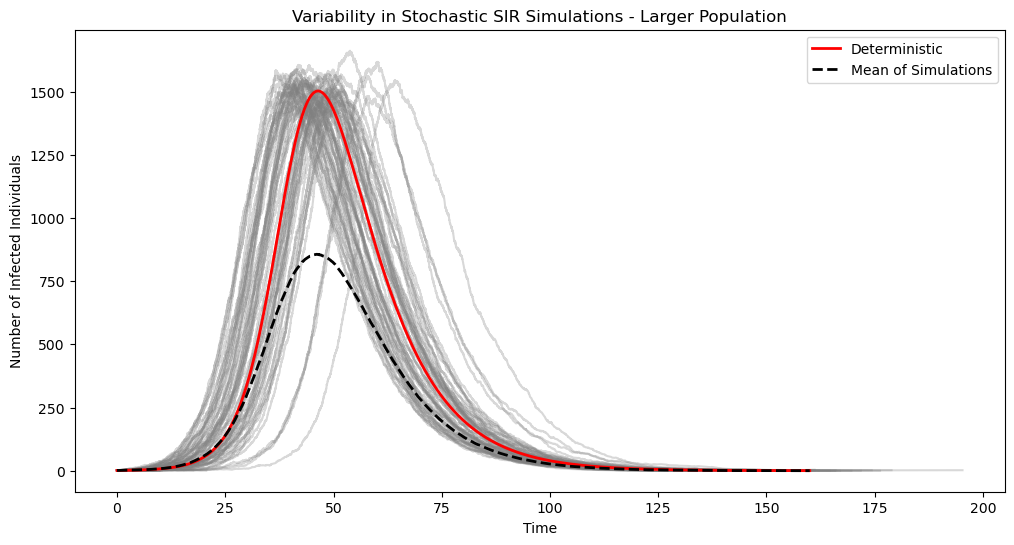

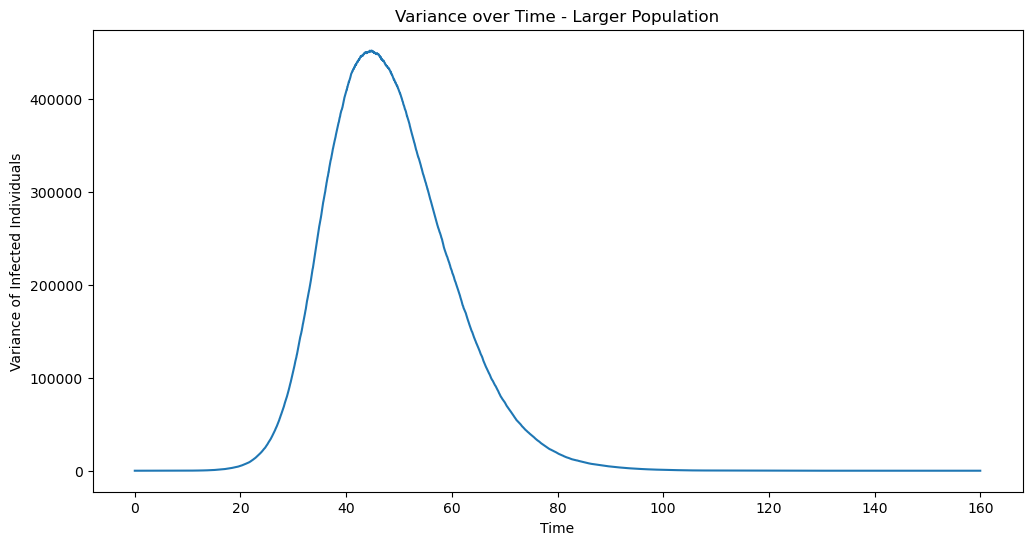

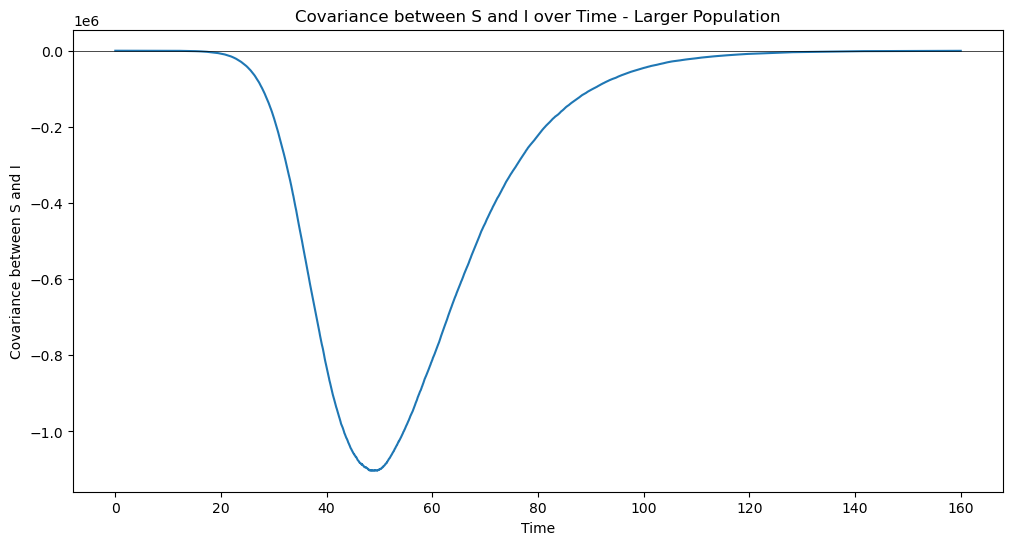

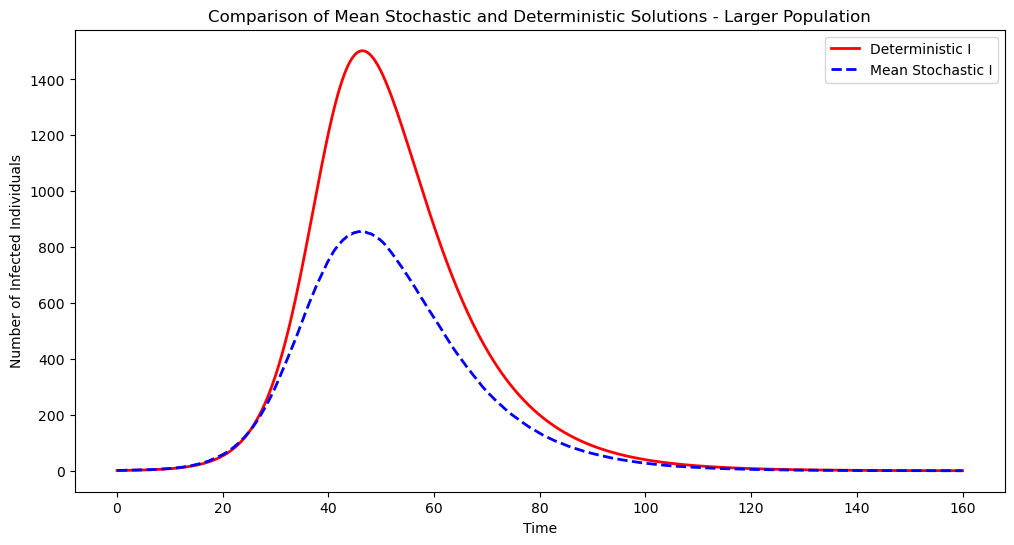

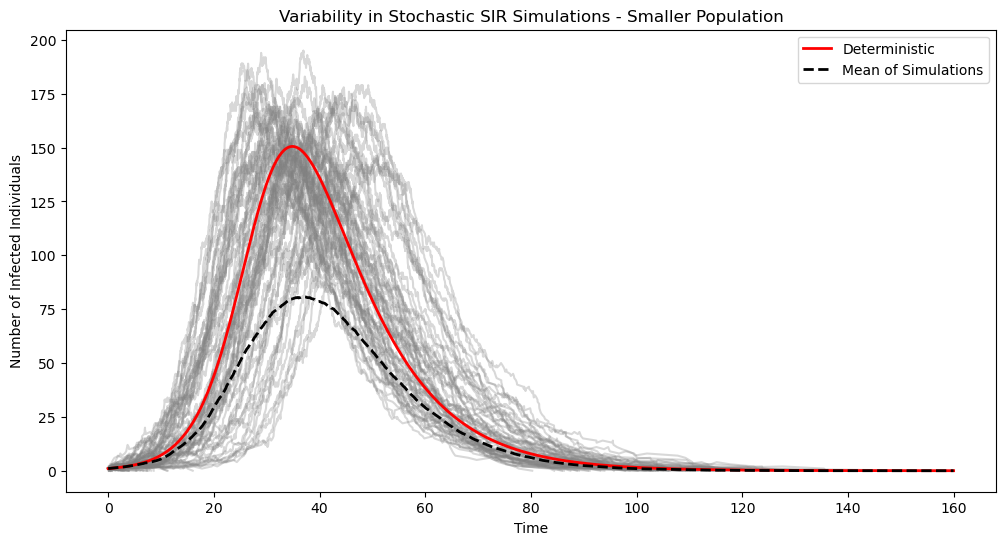

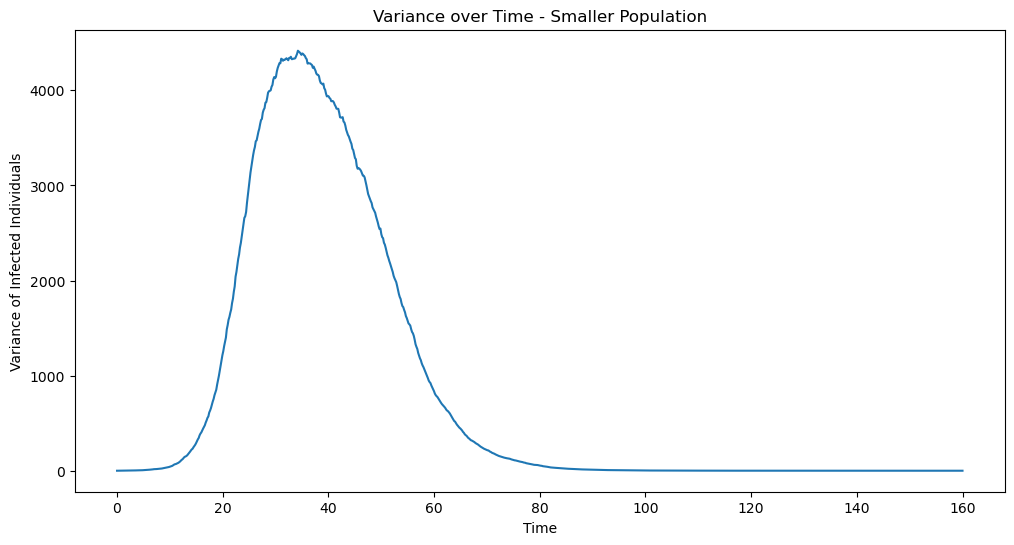

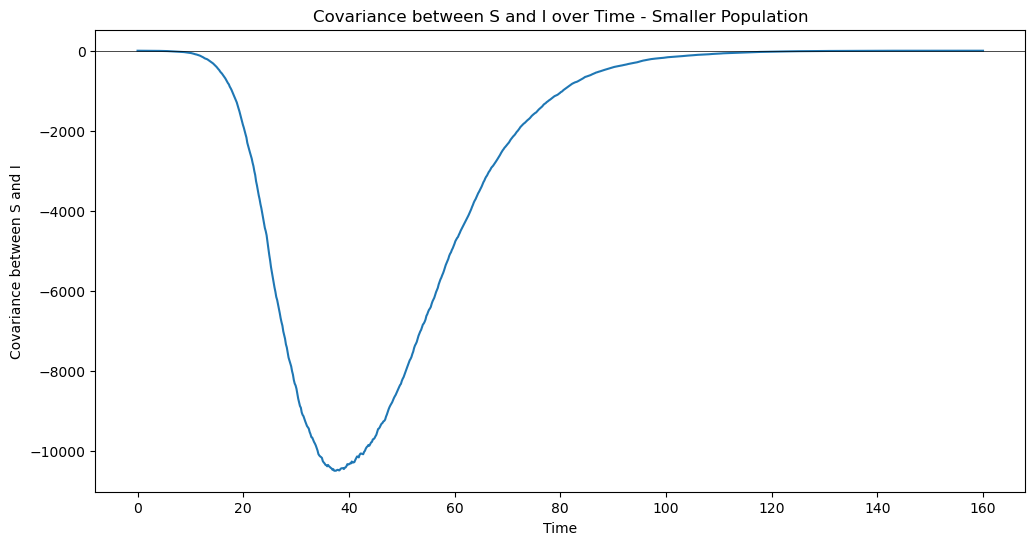

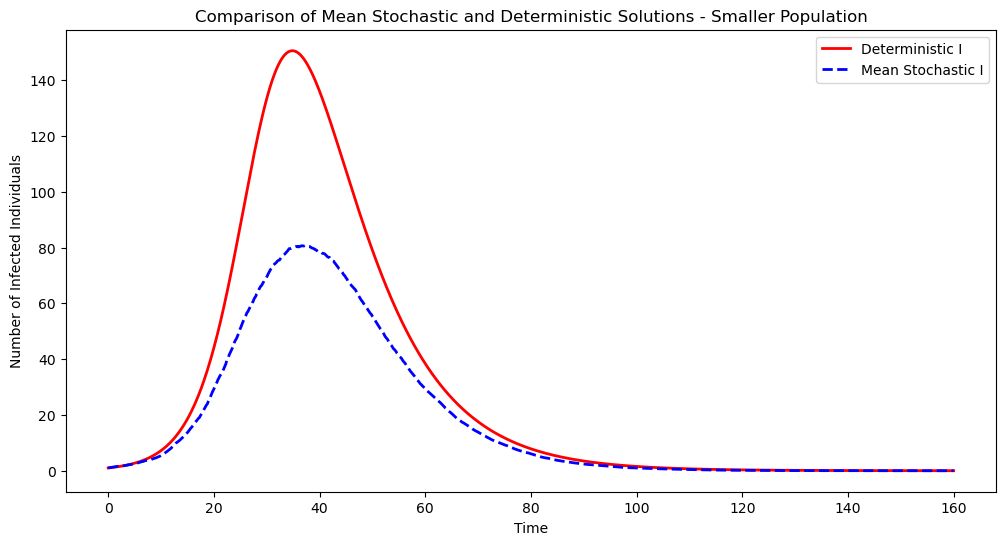

In [4]:
# Parameter sets
parameter_sets = [
    {'beta': 0.3, 'gamma': 0.1, 'N': 1000, 'label': 'Baseline'},
    {'beta': 0.5, 'gamma': 0.1, 'N': 1000, 'label': 'Higher Transmission'},
    {'beta': 0.1, 'gamma': 0.1, 'N': 1000, 'label': 'Lower Transmission'},
    {'beta': 0.3, 'gamma': 0.2, 'N': 1000, 'label': 'Faster Recovery'},
    {'beta': 0.3, 'gamma': 0.1, 'N': 5000, 'label': 'Larger Population'},
    {'beta': 0.3, 'gamma': 0.1, 'N': 500, 'label': 'Smaller Population'}
]

num_simulations = 100  # Number of stochastic simulations
t_max = 160  # Maximum time
t_det = np.linspace(0, t_max, 1000)  # Time points for deterministic solution

# Loop over parameter sets
for params in parameter_sets:
    beta = params['beta']
    gamma = params['gamma']
    N = params['N']
    label = params['label']
    
    S0 = N - 1
    I0 = 1
    R0 = 0

    # Solve deterministic SIR model
    y0 = [S0, I0, R0]
    ret = odeint(SIR_ode, y0, t_det, args=(beta, gamma, N))
    S_det, I_det, R_det = ret.T

    # Lists to store multiple simulation results
    I_values = []
    S_values = []
    time_values = []

    # Run multiple stochastic simulations
    for sim in range(num_simulations):
        times, S_vals, I_vals, _ = gillespie_SIR(beta, gamma, N, S0, I0, R0, t_max)
        I_values.append(I_vals)
        S_values.append(S_vals)
        time_values.append(times)

    # Align data for statistical analysis
    max_len = max(len(tv) for tv in time_values)
    time_grid = np.linspace(0, t_max, max_len)

    I_interp = np.zeros((num_simulations, max_len))
    S_interp = np.zeros((num_simulations, max_len))

    for i in range(num_simulations):
        I_interp[i, :] = np.interp(time_grid, time_values[i], I_values[i])
        S_interp[i, :] = np.interp(time_grid, time_values[i], S_values[i])

    # Compute statistics
    I_mean = np.mean(I_interp, axis=0)
    I_var = np.var(I_interp, axis=0)
    S_mean = np.mean(S_interp, axis=0)
    S_var = np.var(S_interp, axis=0)
    cov_SI = np.mean((S_interp - S_mean) * (I_interp - I_mean), axis=0)

    # Plotting results

    # Plot multiple stochastic simulations and deterministic solution
    plt.figure(figsize=(12, 6))
    for i in range(num_simulations):
        plt.plot(time_values[i], I_values[i], color='grey', alpha=0.3)
    plt.plot(t_det, I_det, 'r', lw=2, label='Deterministic')
    plt.plot(time_grid, I_mean, 'k--', lw=2, label='Mean of Simulations')
    plt.xlabel('Time')
    plt.ylabel('Number of Infected Individuals')
    plt.title(f'Variability in Stochastic SIR Simulations - {label}')
    plt.legend()
    plt.show()

    # Plot variance of I over time
    plt.figure(figsize=(12, 6))
    plt.plot(time_grid, I_var)
    plt.xlabel('Time')
    plt.ylabel('Variance of Infected Individuals')
    plt.title(f'Variance over Time - {label}')
    plt.show()

    # Plot covariance between S and I over time
    plt.figure(figsize=(12, 6))
    plt.plot(time_grid, cov_SI)
    plt.xlabel('Time')
    plt.ylabel('Covariance between S and I')
    plt.title(f'Covariance between S and I over Time - {label}')
    plt.axhline(0, color='black', lw=0.5)
    plt.show()

    # Comparison of mean stochastic and deterministic solutions
    plt.figure(figsize=(12, 6))
    plt.plot(t_det, I_det, 'r', lw=2, label='Deterministic I')
    plt.plot(time_grid, I_mean, 'b--', lw=2, label='Mean Stochastic I')
    plt.xlabel('Time')
    plt.ylabel('Number of Infected Individuals')
    plt.title(f'Comparison of Mean Stochastic and Deterministic Solutions - {label}')
    plt.legend()
    plt.show()

    # Additional analysis and plots can be added here


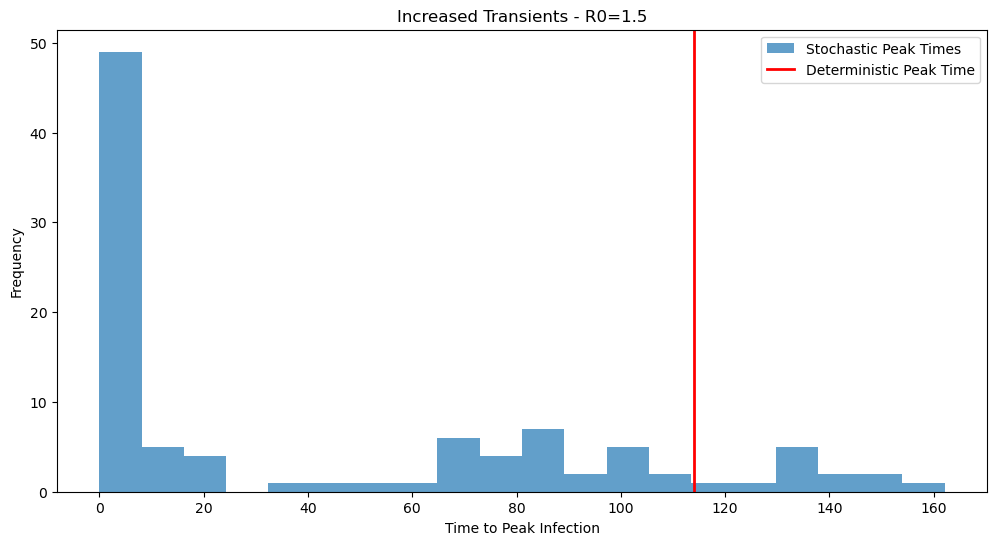

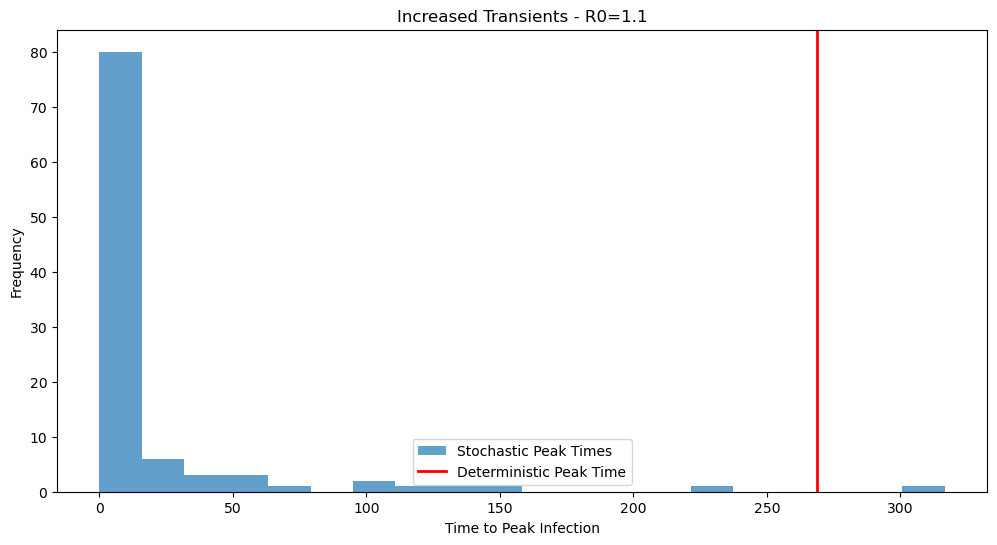

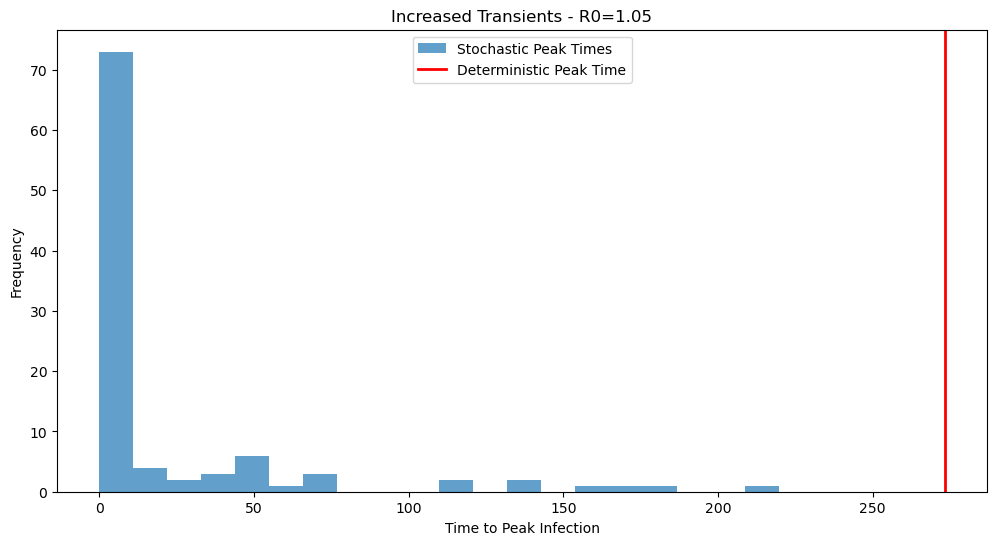

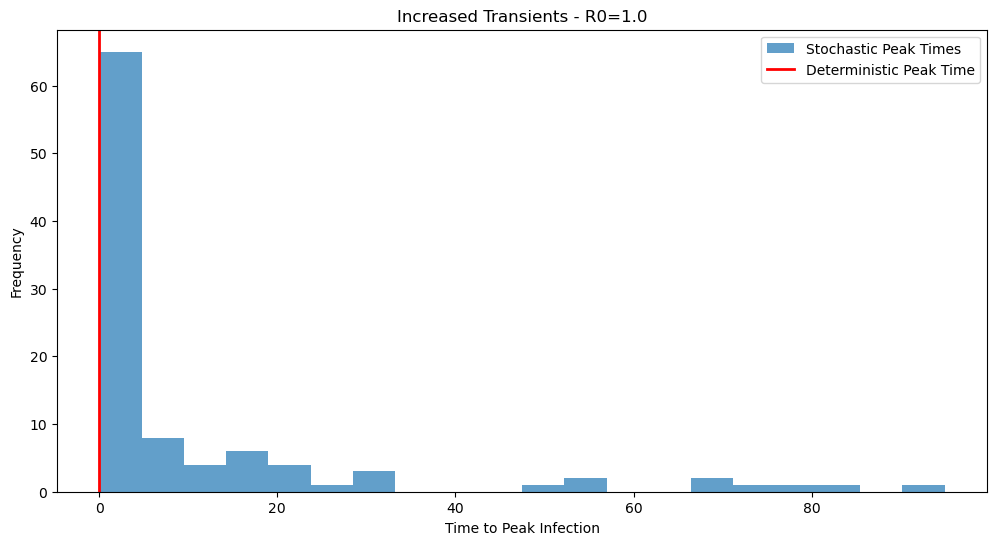

In [5]:
# Function to run Gillespie simulation and record peak time
def gillespie_SIR_peak_time(beta, gamma, N, S0, I0, R0, t_max):
    S = S0
    I = I0
    R = R0
    t = 0

    times = [t]
    I_vals = [I]
    peak_I = I
    peak_time = t

    while t < t_max and I > 0:
        a1 = beta * S * I / N
        a2 = gamma * I
        a0 = a1 + a2

        if a0 == 0:
            break

        r1 = np.random.uniform()
        delta_t = -np.log(r1) / a0
        t += delta_t

        r2 = np.random.uniform()
        if r2 < a1 / a0:
            S -= 1
            I += 1
        else:
            I -= 1
            R += 1

        times.append(t)
        I_vals.append(I)

        if I > peak_I:
            peak_I = I
            peak_time = t

    return np.array(times), np.array(I_vals), peak_time

parameter_sets = [
    {'beta': 0.15, 'gamma': 0.1, 'N': 1000, 'label': 'R0=1.5'},
    {'beta': 0.11, 'gamma': 0.1, 'N': 1000, 'label': 'R0=1.1'},
    {'beta': 0.105, 'gamma': 0.1, 'N': 1000, 'label': 'R0=1.05'},
    {'beta': 0.1, 'gamma': 0.1, 'N': 1000, 'label': 'R0=1.0'},
]

num_simulations = 100
t_max = 500
I0 = 1

for params in parameter_sets:
    beta = params['beta']
    gamma = params['gamma']
    N = params['N']
    label = params['label']
    S0 = N - I0

    # Solve deterministic model
    t_det = np.linspace(0, t_max, 1000)
    y0 = [S0, I0, 0]
    ret = odeint(SIR_ode, y0, t_det, args=(beta, gamma, N))
    S_det, I_det, R_det = ret.T
    peak_time_det = t_det[np.argmax(I_det)]

    peak_times_stoch = []
    I_values = []
    time_values = []

    for sim in range(num_simulations):
        times, I_vals, peak_time = gillespie_SIR_peak_time(beta, gamma, N, S0, I0, 0, t_max)
        peak_times_stoch.append(peak_time)
        I_values.append(I_vals)
        time_values.append(times)

    # Plot histogram of peak times
    plt.figure(figsize=(12, 6))
    plt.hist(peak_times_stoch, bins=20, alpha=0.7, label='Stochastic Peak Times')
    plt.axvline(peak_time_det, color='red', lw=2, label='Deterministic Peak Time')
    plt.xlabel('Time to Peak Infection')
    plt.ylabel('Frequency')
    plt.title(f'Increased Transients - {label}')
    plt.legend()
    plt.show()


N=500, R0=1.00, Extinction Probability=1.000
N=500, R0=1.04, Extinction Probability=1.000
N=500, R0=1.07, Extinction Probability=1.000
N=500, R0=1.11, Extinction Probability=1.000
N=500, R0=1.15, Extinction Probability=1.000
N=500, R0=1.19, Extinction Probability=1.000
N=500, R0=1.23, Extinction Probability=1.000
N=500, R0=1.26, Extinction Probability=1.000
N=500, R0=1.30, Extinction Probability=1.000
N=500, R0=1.34, Extinction Probability=1.000
N=500, R0=1.38, Extinction Probability=1.000
N=500, R0=1.41, Extinction Probability=1.000
N=500, R0=1.45, Extinction Probability=1.000
N=500, R0=1.49, Extinction Probability=1.000
N=500, R0=1.52, Extinction Probability=1.000
N=500, R0=1.56, Extinction Probability=1.000
N=500, R0=1.60, Extinction Probability=1.000
N=500, R0=1.64, Extinction Probability=1.000
N=500, R0=1.67, Extinction Probability=1.000
N=500, R0=1.71, Extinction Probability=1.000
N=500, R0=1.75, Extinction Probability=1.000
N=1000, R0=1.00, Extinction Probability=1.000
N=1000, R

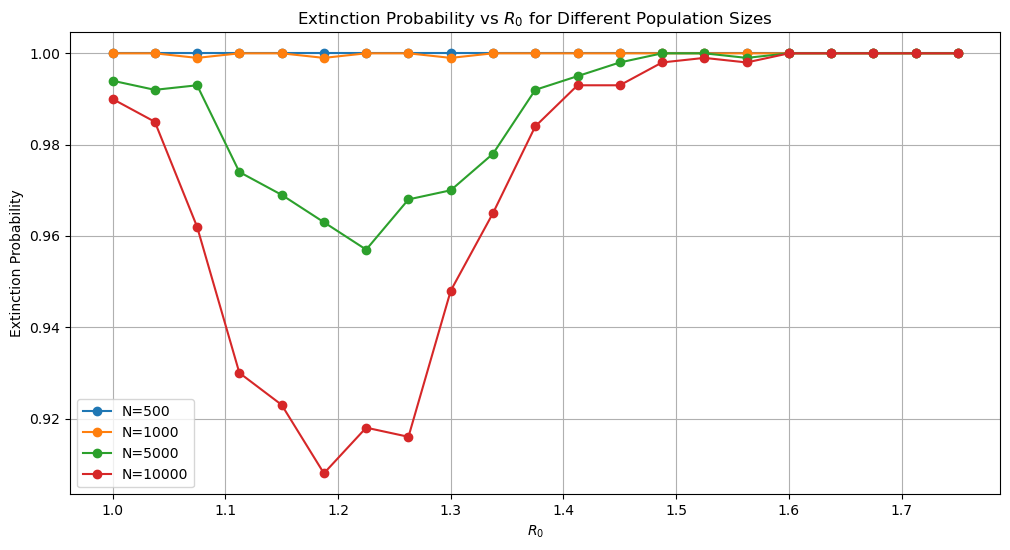

In [6]:
# Gillespie algorithm function to check for extinction
def gillespie_SIR_extinction(beta, gamma, N, S0, I0, R0, t_max):
    S = S0
    I = I0
    R = R0
    t = 0

    while t < t_max:
        if I == 0:
            # Extinction occurred
            return True
        # Calculate rates
        a1 = beta * S * I / N  # Infection rate
        a2 = gamma * I         # Recovery rate
        a0 = a1 + a2           # Total rate

        if a0 == 0:
            break

        # Time to next event
        r1 = np.random.uniform()
        delta_t = -np.log(r1) / a0
        t += delta_t

        # Determine event
        r2 = np.random.uniform()
        if r2 < a1 / a0:
            # Infection event
            S -= 1
            I += 1
        else:
            # Recovery event
            I -= 1
            R += 1

    # If simulation ends without I reaching 0, extinction did not occur
    return False

# Parameters
gamma = 0.1  # Fixed recovery rate
t_max = 500
n_simulations = 1000  # Number of simulations per parameter set
I0 = 1  # Initial number of infected individuals

# R0 and N values to test
R0_values = np.linspace(1.0, 1.75, 21)  # From 1.0 to 3.0 in steps of 0.1
N_values = [500, 1000, 5000, 10000]

# Store results
extinction_probabilities = {}

for N in N_values:
    extinction_probabilities[N] = []
    S0 = N - I0
    for R0 in R0_values:
        beta = R0 * gamma  # Adjust beta to get desired R0
        extinctions = 0
        for _ in range(n_simulations):
            extinct = gillespie_SIR_extinction(beta, gamma, N, S0, I0, 0, t_max)
            if extinct:
                extinctions += 1
        P_extinct = extinctions / n_simulations
        extinction_probabilities[N].append(P_extinct)
        print(f"N={N}, R0={R0:.2f}, Extinction Probability={P_extinct:.3f}")

# Plotting the results
plt.figure(figsize=(12, 6))
for N in N_values:
    plt.plot(R0_values, extinction_probabilities[N], marker='o', label=f'N={N}')
plt.xlabel('$R_0$')
plt.ylabel('Extinction Probability')
plt.title('Extinction Probability vs $R_0$ for Different Population Sizes')
plt.legend()
plt.grid(True)
plt.show()


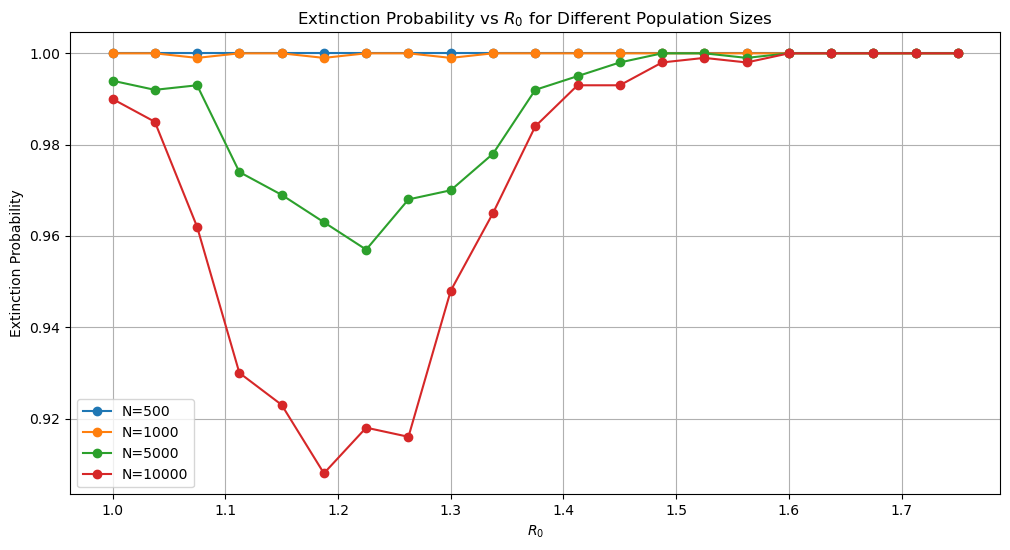

In [7]:
# Plotting the results
plt.figure(figsize=(12, 6))
for N in N_values:
    plt.plot(R0_values, extinction_probabilities[N], marker='o', label=f'N={N}')
plt.xlabel('$R_0$')
plt.ylabel('Extinction Probability')
plt.title('Extinction Probability vs $R_0$ for Different Population Sizes')
plt.legend()
plt.grid(True)
plt.show()

# Spatial Models - Networks

In [8]:
# Import the csv file
df = pd.read_csv('transmission_network.csv', sep=';')
df = df.rename(columns={df.columns[0]:'nodes'})

In [9]:
# Create graph object and add nodes to it
Graph_obj = nx.Graph()
nodes = df['nodes'].tolist()
Graph_obj.add_nodes_from(nodes)

In [10]:
# Add edges between nodes based on the csv-file
for _, row in df.iterrows():
    source_node = row['nodes']
    for col_name, edge_value in row.items():
        if col_name != 'nodes' and edge_value != 0:
            Graph_obj.add_edge(source_node, int(col_name))

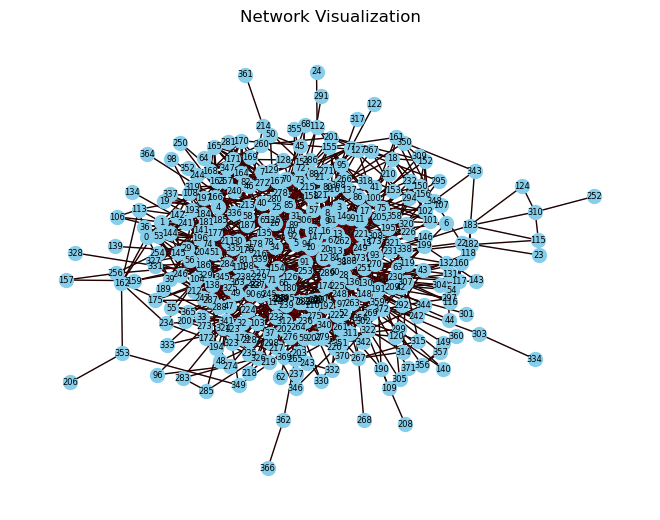

In [11]:
# Relabel the nodes
Graph_obj = nx.convert_node_labels_to_integers(Graph_obj, first_label=0)

# create a layout for the nodes
pos = nx.kamada_kawai_layout(Graph_obj)

# draw the nodes and edges
nx.draw(Graph_obj, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_color='black')
nx.draw_networkx_edges(Graph_obj, pos, edge_color='red', width=0.1)

# display the graph
plt.axis('off')
plt.title("Network Visualization")
plt.show()

In [12]:
# Generate SIR model object
SIR_model = ep.SIRModel(Graph_obj)

# Set parameter values
betas = np.linspace(0.1, 3, 101)
gammas = np.linspace(0.01, 1, 101)
percentage_infected = 0.01
nr_iterations = 200

# Pre-allocate variables.
S_store = np.zeros((len(betas), len(gammas), nr_iterations))
I_store = np.zeros((len(betas), len(gammas), nr_iterations))
R_store = np.zeros((len(betas), len(gammas), nr_iterations))

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected)

for beta_ix, beta in enumerate(betas):
    for gamma_ix, gamma in enumerate(gammas):
        # (Re)set every node as susceptible
        for node in Graph_obj.nodes():
            SIR_model.status[node] = 0
            
        # Set model configurations
        cfg.add_model_parameter('beta', beta)
        cfg.add_model_parameter('gamma', gamma)
        SIR_model.set_initial_status(cfg)
        iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
        trends = SIR_model.build_trends(iterations)
        
        # Extract values based on updated structure
        node_counts = trends[0]['trends']['node_count']
        S = node_counts[0]
        I = node_counts[1]
        R = node_counts[2]

        # Store the sums for averages
        S_store[beta_ix, gamma_ix] = S
        I_store[beta_ix, gamma_ix] = I
        R_store[beta_ix, gamma_ix] = R

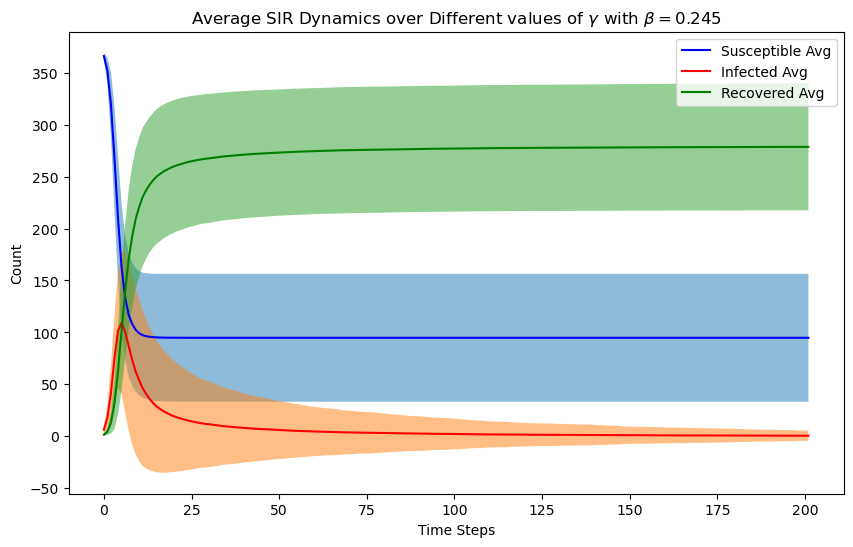

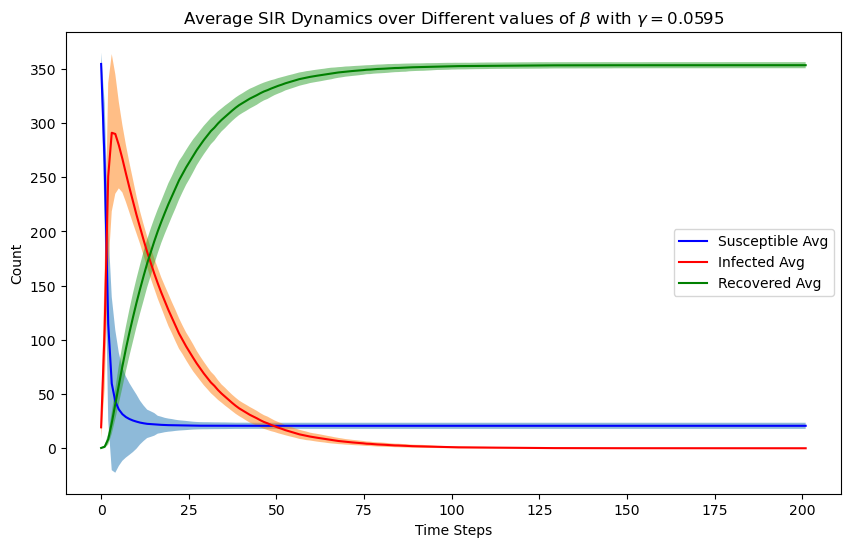

In [13]:
beta_index = 5
Gamma_index = 5

S_mean_0 = np.mean(S_store[beta_index], axis=0)
I_mean_0 = np.mean(I_store[beta_index], axis=0)
R_mean_0 = np.mean(R_store[beta_index], axis=0)
S_std_0 = np.std(S_store[beta_index], axis=0)
I_std_0 = np.std(I_store[beta_index], axis=0)
R_std_0 = np.std(R_store[beta_index], axis=0)

S_mean_1 = np.mean(S_store[:, Gamma_index], axis=0)
I_mean_1 = np.mean(I_store[:, Gamma_index], axis=0)
R_mean_1 = np.mean(R_store[:, Gamma_index], axis=0)
S_std_1 = np.std(S_store[:, Gamma_index], axis=0)
I_std_1 = np.std(I_store[:, Gamma_index], axis=0)
R_std_1 = np.std(R_store[:, Gamma_index], axis=0)

x = np.linspace(0, 201, 200)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S_mean_0, label="Susceptible Avg", color='blue')
plt.fill_between(x, S_mean_0 - S_std_0,S_mean_0 + S_std_0, alpha=0.5) 
plt.plot(x, I_mean_0, label="Infected Avg", color='red')
plt.fill_between(x, I_mean_0 - I_std_0,I_mean_0 + I_std_0, alpha=0.5) 
plt.plot(x, R_mean_0, label="Recovered Avg", color='green')
plt.fill_between(x, R_mean_0 - R_std_0,R_mean_0 + R_std_0, alpha=0.5) 
plt.title(fr"Average SIR Dynamics over Different values of $\gamma$ with $\beta = {betas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S_mean_1, label="Susceptible Avg", color='blue')
plt.fill_between(x, S_mean_1 - S_std_1,S_mean_1 + S_std_1, alpha=0.5) 
plt.plot(x, I_mean_1, label="Infected Avg", color='red')
plt.fill_between(x, I_mean_1 - I_std_1,I_mean_1 + I_std_1, alpha=0.5) 
plt.plot(x, R_mean_1, label="Recovered Avg", color='green')
plt.fill_between(x, R_mean_1 - R_std_1,R_mean_1 + R_std_1, alpha=0.5) 
plt.title(fr"Average SIR Dynamics over Different values of $\beta$ with $\gamma = {gammas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()

## Similar networks

In [14]:
def statistic_func(Graph):
    # Pre-allocating return variable
    stats = {}
    
    stats['Nr_of_nodes'] = Graph.number_of_nodes()
    stats['Nr_of_edges'] = Graph.number_of_edges()
        

    degrees = [degree for degree in Graph.degree()]
    stats['Average_degree'] = np.mean(degrees)
    
    
    if degrees:
        stats['average_clustering_coefficient'] = nx.average_clustering(Graph)
        stats['density'] = nx.density(Graph)
        
        degree_centralities = nx.degree_centrality(Graph)
        stats['average_degree_centrality'] = np.mean(list(degree_centralities.values()))
        
        betweenness_centralities = nx.betweenness_centrality(Graph)
        stats['average_betweenness_centrality'] = np.mean(list(betweenness_centralities.values()))
        
        closeness_centrality = nx.closeness_centrality(Graph)
        stats['average_closeness_centrality'] = np.mean(list(closeness_centrality.values()))
        
        if nx.is_connected(Graph):
            stats['diameter'] = nx.diameter(Graph)
            stats['average_shortest_path_length'] = nx.average_shortest_path_length(Graph)
            
        else:
            stats['diameter'] = None
            stats['average_shortest_path_length'] = None
    else:
        stats['average_clustering_coefficient'] = None
        stats['density'] = None
        stats['average_degree_centrality'] = None
        stats['average_betweenness_centrality'] = None
        stats['average_closeness_centrality'] = None

    return stats

### Erdös-Rénji Network


In [15]:
network_size = np.arange(50, 550, 50)
connection_probability = np.arange(0.05, 1.05, 0.05)

results_ER = []

for size in network_size:
    for p in connection_probability:
        Graph_ER = nx.erdos_renyi_graph(size, p)
        stats_ER = statistic_func(Graph_ER)
        results_ER.append(stats_ER)

df_ER = pd.DataFrame(results_ER)

In [16]:
custom_summary = df_ER.groupby(df_ER.columns[0]).agg(['mean', 'std', 'median', 'min', 'max','var'])
display(custom_summary)

Nr_of_edges                                                     \
                   mean           std   median   min     max           var   
Nr_of_nodes                                                                  
50               641.50    363.029867    646.5    58    1225  1.317907e+05   
100             2590.35   1475.041847   2588.5   248    4950  2.175748e+06   
150             5864.55   3316.317956   5823.0   545   11175  1.099796e+07   
200            10452.80   5896.033043  10415.5  1033   19900  3.476321e+07   
250            16338.10   9197.130101  16291.5  1557   31125  8.458720e+07   
300            23561.85  13295.062880  23595.0  2265   44850  1.767587e+08   
350            32049.55  18073.709305  32073.0  3031   61075  3.266590e+08   
400            41872.75  23602.228264  41933.5  3984   79800  5.570652e+08   
450            53035.50  29897.533381  53007.0  5021  101025  8.938625e+08   
500            65474.40  36898.360659  65580.0  6136  124750  1.361489e+09   

            Average_degree                                     ... diameter  \
                      mean        std      median         min  ...   median   
Nr_of_nodes                                                    ...            
50               25.080000   7.260597   25.180000   13.410000  ...      2.0   
100              50.653500  14.750418   50.635000   27.230000  ...      2.0   
150              76.347000  22.108786   76.070000   40.883333  ...      2.0   
200             102.014000  29.480165  101.827500   54.915000  ...      2.0   
250             127.602400  36.788520  127.416000   68.478000  ...      2.0   
300             153.289500  44.316876  153.400000   82.300000  ...      2.0   
350             178.820143  51.639169  178.887143   95.910000  ...      2.0   
400             204.431875  59.005571  204.583750  109.710000  ...      2.0   
450             230.106667  66.438963  230.043333  123.407778  ...      2.0   
500             255.698800  73.796721  255.910000  137.022000  ...      2.0   

                                average_shortest_path_length            \
             min  max       var                         mean       std   
Nr_of_nodes                                                              
50           1.0  5.0  0.812865                     1.512782  0.404471   
100          1.0  6.0  1.094737                     1.556535  0.480095   
150          1.0  5.0  0.618421                     1.526251  0.411374   
200          1.0  5.0  0.618421                     1.510264  0.373116   
250          1.0  4.0  0.378947                     1.504652  0.360250   
300          1.0  4.0  0.344737                     1.498983  0.348814   
350          1.0  4.0  0.344737                     1.496892  0.342347   
400          1.0  3.0  0.200000                     1.493870  0.334902   
450          1.0  4.0  0.344737                     1.491233  0.329624   
500          1.0  3.0  0.155263                     1.489695  0.325717   

                                                
               median  min       max       var  
Nr_of_nodes                                     
50           1.453061  1.0  2.587755  0.163596  
100          1.477071  1.0  3.061616  0.230491  
150          1.478926  1.0  2.727875  0.169228  
200          1.476608  1.0  2.520050  0.139216  
250          1.476578  1.0  2.464771  0.129780  
300          1.473913  1.0  2.390546  0.121671  
350          1.474859  1.0  2.354073  0.117202  
400          1.474518  1.0  2.302607  0.112159  
450          1.475308  1.0  2.264014  0.108652  
500          1.474309  1.0  2.236505  0.106091  

[10 rows x 54 columns]

In [17]:
ps = np.arange(0.018, 0.02, 0.001)
for p in ps:
    Graph_ER = nx.erdos_renyi_graph(374, p)
    stats_ER = statistic_func(Graph_ER)
    print(p, stats_ER['Nr_of_edges'])

0.018 1321
0.019 1389
0.02 1461


In [18]:
# Generate Barabasi-Albert graph similar to the given model
Graph_ER = nx.erdos_renyi_graph(374, 0.019)

# Generate SIR model object
SIR_model = ep.SIRModel(Graph_ER)

# Set parameter values
beta = 1.5
gamma = 0.3
percentage_infected = 5/374
nr_iterations = 200

# Pre-allocate variables.
S_store = np.zeros((nr_iterations))
I_store = np.zeros((nr_iterations))
R_store = np.zeros((nr_iterations))

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected)


# Set every node as susceptible
for node in Graph_obj.nodes():
    SIR_model.status[node] = 0
    
# Set model configurations
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
SIR_model.set_initial_status(cfg)
iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
trends = SIR_model.build_trends(iterations)

# Extract values based on updated structure
node_counts = trends[0]['trends']['node_count']
S = node_counts[0]
I = node_counts[1]
R = node_counts[2]

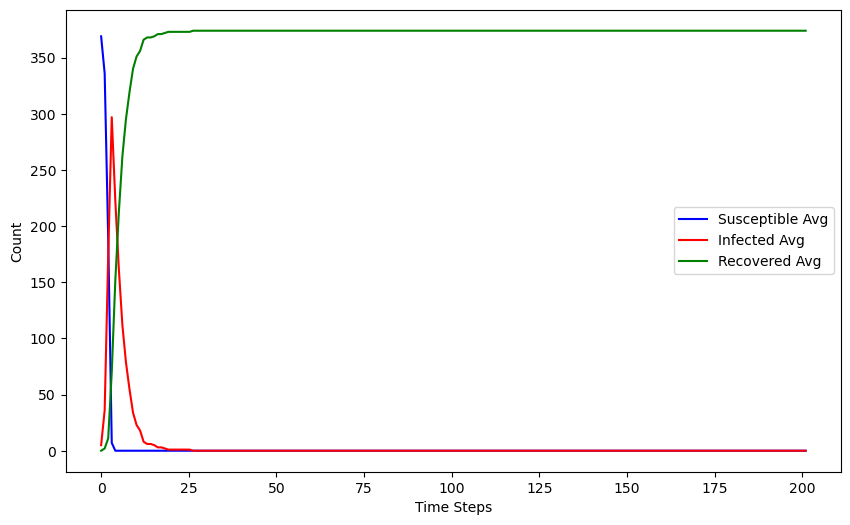

In [19]:
x = np.linspace(0, nr_iterations+1, nr_iterations)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S, label="Susceptible Avg", color='blue')
plt.plot(x, I, label="Infected Avg", color='red')
plt.plot(x, R, label="Recovered Avg", color='green')
# plt.title(fr"Average SIR Dynamics over Different values of $\gamma$ with $\beta = {betas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()


## Watts-Stograz network

In [20]:
nodes = np.arange(50, 550, 50) 
k_values = np.arange(1,10,1)
p_values = np.linspace(0.1, 1, 10)

results_WS = []

for size in nodes:
    for k in k_values:
        for p in p_values:
            Graph_WS = nx.watts_strogatz_graph(size, k, p)
            stats_WR = statistic_func(Graph_WS)
            results_WS.append(stats_WR)
            
df_WS = pd.DataFrame(results_WS)

c:\Users\kevin\anaconda3\envs\ABM\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\kevin\anaconda3\envs\ABM\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [21]:
custom_summary = df_WS.groupby(df_WS.columns[0]).agg(['mean', 'std', 'median', 'min', 'max','var'])
display(custom_summary)

Nr_of_edges                                                \
                   mean         std  median  min   max            var   
Nr_of_nodes                                                             
0                   0.0    0.000000     0.0    0     0       0.000000   
50                125.0   56.254395   125.0   50   200    3164.556962   
100               250.0  112.508790   250.0  100   400   12658.227848   
150               375.0  168.763185   375.0  150   600   28481.012658   
200               500.0  225.017580   500.0  200   800   50632.911392   
250               625.0  281.271975   625.0  250  1000   79113.924051   
300               750.0  337.526370   750.0  300  1200  113924.050633   
350               875.0  393.780765   875.0  350  1400  155063.291139   
400              1000.0  450.035160  1000.0  400  1600  202531.645570   
450              1125.0  506.289555  1125.0  450  1800  256329.113924   
500              1250.0  562.543950  1250.0  500  2000  316455.696203   

            Average_degree                            ... diameter       \
                      mean       std  median     min  ...   median  min   
Nr_of_nodes                                           ...                 
0                      NaN       NaN     NaN     NaN  ...      NaN  NaN   
50                   14.75  1.125088   14.75   13.25  ...      5.0  3.0   
100                  27.25  1.125088   27.25   25.75  ...      5.0  4.0   
150                  39.75  1.125088   39.75   38.25  ...      6.0  4.0   
200                  52.25  1.125088   52.25   50.75  ...      6.0  4.0   
250                  64.75  1.125088   64.75   63.25  ...      6.0  5.0   
300                  77.25  1.125088   77.25   75.75  ...      7.0  5.0   
350                  89.75  1.125088   89.75   88.25  ...      6.5  5.0   
400                 102.25  1.125088  102.25  100.75  ...      7.0  5.0   
450                 114.75  1.125088  114.75  113.25  ...      6.0  5.0   
500                 127.25  1.125088  127.25  125.75  ...      7.0  5.0   

                               average_shortest_path_length             \
               max         var                         mean        std   
Nr_of_nodes                                                              
0              NaN         NaN                          NaN        NaN   
50            29.0   35.787123                     3.419017   2.160966   
100           63.0  154.650704                     4.730377   4.199046   
150           55.0  112.609615                     4.457512   3.835616   
200           76.0  195.123926                     5.258137   5.086226   
250           65.0  157.346620                     5.133697   4.545828   
300           89.0  402.662830                     6.543314   7.174256   
350          125.0  459.688811                     6.069663   7.102714   
400           97.0  282.324405                     5.539379   5.778888   
450          114.0  253.522210                     5.184630   5.484979   
500          165.0  928.722844                     7.581959  10.955264   

                                                        
               median       min        max         var  
Nr_of_nodes                                             
0                 NaN       NaN        NaN         NaN  
50           2.522449  2.042449  11.404898    4.669776  
100          3.056566  2.406061  21.979798   17.631991  
150          3.254049  2.607696  20.321432   14.711948  
200          3.520000  2.754523  27.596683   25.869695  
250          3.653365  2.859213  25.529124   20.664554  
300          3.902051  2.958751  32.336611   51.469944  
350          3.899763  3.039001  42.389521   50.448547  
400          3.877444  3.108659  35.400050   33.395548  
450          3.862826  3.171928  39.367107   30.084994  
500          4.145042  3.222878  58.658052  120.017812  

[11 rows x 54 columns]

In [22]:
display(df_WS)

Nr_of_nodes  Nr_of_edges  Average_degree  average_clustering_coefficient  \
0              0            0             NaN                             NaN   
1              0            0             NaN                             NaN   
2              0            0             NaN                             NaN   
3              0            0             NaN                             NaN   
4              0            0             NaN                             NaN   
..           ...          ...             ...                             ...   
895          500         2000          128.75                        0.053489   
896          500         2000          128.75                        0.028454   
897          500         2000          128.75                        0.022408   
898          500         2000          128.75                        0.012871   
899          500         2000          128.75                        0.012836   

      density  average_degree_centrality  average_betweenness_centrality  \
0         NaN                        NaN                             NaN   
1         NaN                        NaN                             NaN   
2         NaN                        NaN                             NaN   
3         NaN                        NaN                             NaN   
4         NaN                        NaN                             NaN   
..        ...                        ...                             ...   
895  0.016032                   0.016032                        0.004587   
896  0.016032                   0.016032                        0.004513   
897  0.016032                   0.016032                        0.004482   
898  0.016032                   0.016032                        0.004481   
899  0.016032                   0.016032                        0.004471   

     average_closeness_centrality  diameter  average_shortest_path_length  
0                             NaN       NaN                           NaN  
1                             NaN       NaN                           NaN  
2                             NaN       NaN                           NaN  
3                             NaN       NaN                           NaN  
4                             NaN       NaN                           NaN  
..                            ...       ...                           ...  
895                      0.304860       5.0                      3.284441  
896                      0.308349       5.0                      3.247415  
897                      0.309839       5.0                      3.232112  
898                      0.309934       5.0                      3.231487  
899                      0.310402       5.0                      3.226629  

[900 rows x 10 columns]

In [23]:
# Generate Barabasi-Albert graph similar to the given model
Graph_WS = nx.watts_strogatz_graph(374, 4, 0.9)

# Generate SIR model object
SIR_model = ep.SIRModel(Graph_WS)

# Set parameter values
beta = 1.5
gamma = 0.3
percentage_infected = 5/374
nr_iterations = 100

# Pre-allocate variables.
S_store = np.zeros((nr_iterations))
I_store = np.zeros((nr_iterations))
R_store = np.zeros((nr_iterations))

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected)


# Set every node as susceptible
for node in Graph_obj.nodes():
    SIR_model.status[node] = 0
    
# Set model configurations
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
SIR_model.set_initial_status(cfg)
iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
trends = SIR_model.build_trends(iterations)

# Extract values based on updated structure
node_counts = trends[0]['trends']['node_count']
S = node_counts[0]
I = node_counts[1]
R = node_counts[2]

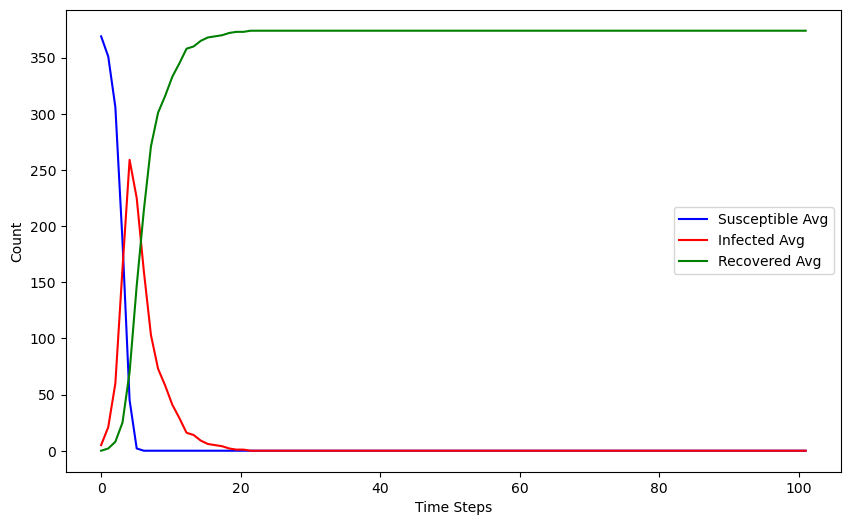

In [24]:
x = np.linspace(0, nr_iterations+1, nr_iterations)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S, label="Susceptible Avg", color='blue')
plt.plot(x, I, label="Infected Avg", color='red')
plt.plot(x, R, label="Recovered Avg", color='green')
# plt.title(fr"Average SIR Dynamics over Different values of $\gamma$ with $\beta = {betas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()


## Barabási-Albert network

In [25]:
nodes = np.arange(50,550,50)
m_values = np.arange(1,11,10)

results_BA = []

for size in nodes:
    for m in m_values:
        Graph_BA = nx.barabasi_albert_graph(size, m)
        stats_BA = statistic_func(Graph_BA)
        results_BA.append(stats_BA)
        
df_BA = pd.DataFrame(results_BA)

In [26]:
custom_summary = df_BA.groupby(df_WS.columns[0]).agg(['mean', 'std', 'median', 'min', 'max','var'])
display(custom_summary)

Nr_of_edges                          Average_degree      \
                   mean std median  min  max var           mean std   
Nr_of_nodes                                                           
50                 49.0 NaN   49.0   49   49 NaN      13.230000 NaN   
100                99.0 NaN   99.0   99   99 NaN      25.740000 NaN   
150               149.0 NaN  149.0  149  149 NaN      38.243333 NaN   
200               199.0 NaN  199.0  199  199 NaN      50.745000 NaN   
250               249.0 NaN  249.0  249  249 NaN      63.246000 NaN   
300               299.0 NaN  299.0  299  299 NaN      75.746667 NaN   
350               349.0 NaN  349.0  349  349 NaN      88.247143 NaN   
400               399.0 NaN  399.0  399  399 NaN     100.747500 NaN   
450               449.0 NaN  449.0  449  449 NaN     113.247778 NaN   
500               499.0 NaN  499.0  499  499 NaN     125.748000 NaN   

                                     ... diameter              \
                 median         min  ...   median min max var   
Nr_of_nodes                          ...                        
50            13.230000   13.230000  ...     10.0  10  10 NaN   
100           25.740000   25.740000  ...     10.0  10  10 NaN   
150           38.243333   38.243333  ...      8.0   8   8 NaN   
200           50.745000   50.745000  ...     14.0  14  14 NaN   
250           63.246000   63.246000  ...     12.0  12  12 NaN   
300           75.746667   75.746667  ...     16.0  16  16 NaN   
350           88.247143   88.247143  ...     14.0  14  14 NaN   
400          100.747500  100.747500  ...     12.0  12  12 NaN   
450          113.247778  113.247778  ...     13.0  13  13 NaN   
500          125.748000  125.748000  ...     15.0  15  15 NaN   

            average_shortest_path_length                                        
                                    mean std    median       min       max var  
Nr_of_nodes                                                                     
50                              3.912653 NaN  3.912653  3.912653  3.912653 NaN  
100                             4.472323 NaN  4.472323  4.472323  4.472323 NaN  
150                             3.982819 NaN  3.982819  3.982819  3.982819 NaN  
200                             5.412965 NaN  5.412965  5.412965  5.412965 NaN  
250                             5.260691 NaN  5.260691  5.260691  5.260691 NaN  
300                             6.563122 NaN  6.563122  6.563122  6.563122 NaN  
350                             5.519116 NaN  5.519116  5.519116  5.519116 NaN  
400                             5.099987 NaN  5.099987  5.099987  5.099987 NaN  
450                             5.386261 NaN  5.386261  5.386261  5.386261 NaN  
500                             6.077275 NaN  6.077275  6.077275  6.077275 NaN  

[10 rows x 54 columns]

## Barabási-Albert SIR spread

In [27]:
# Generate Barabasi-Albert graph similar to the given model
Graph_BA = nx.barabasi_albert_graph(374, 4)

# Generate SIR model object
SIR_model = ep.SIRModel(Graph_BA)

# Set parameter values
beta = 1.5
gamma = 0.3
percentage_infected = 5/374
nr_iterations = 200

# Pre-allocate variables.
S_store = np.zeros((nr_iterations))
I_store = np.zeros((nr_iterations))
R_store = np.zeros((nr_iterations))

# Run experiment
cfg = mc.Configuration()
cfg.add_model_parameter("percentage_infected", percentage_infected)


# Set every node as susceptible
for node in Graph_obj.nodes():
    SIR_model.status[node] = 0
    
# Set model configurations
cfg.add_model_parameter('beta', beta)
cfg.add_model_parameter('gamma', gamma)
SIR_model.set_initial_status(cfg)
iterations = SIR_model.iteration_bunch(nr_iterations, node_status=True)
trends = SIR_model.build_trends(iterations)

# Extract values based on updated structure
node_counts = trends[0]['trends']['node_count']
S = node_counts[0]
I = node_counts[1]
R = node_counts[2]

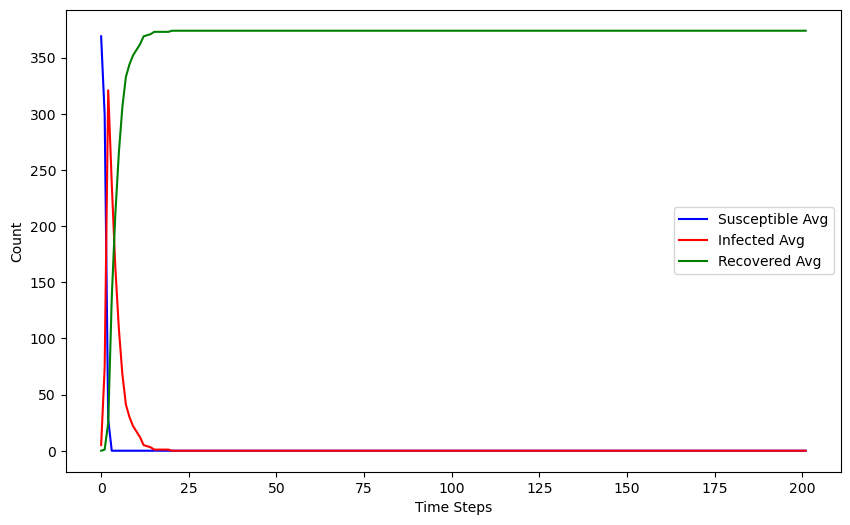

In [28]:
x = np.linspace(0, nr_iterations+1, nr_iterations)

# Plot of average dynamics with standard deviations for I
plt.figure(figsize=(10, 6))
plt.plot(x, S, label="Susceptible Avg", color='blue')
plt.plot(x, I, label="Infected Avg", color='red')
plt.plot(x, R, label="Recovered Avg", color='green')
# plt.title(fr"Average SIR Dynamics over Different values of $\gamma$ with $\beta = {betas[beta_index]}$")
plt.xlabel("Time Steps")
plt.ylabel("Count")
plt.legend()
plt.show()


## Dynamic Vaccination Campaign

### The null strategy

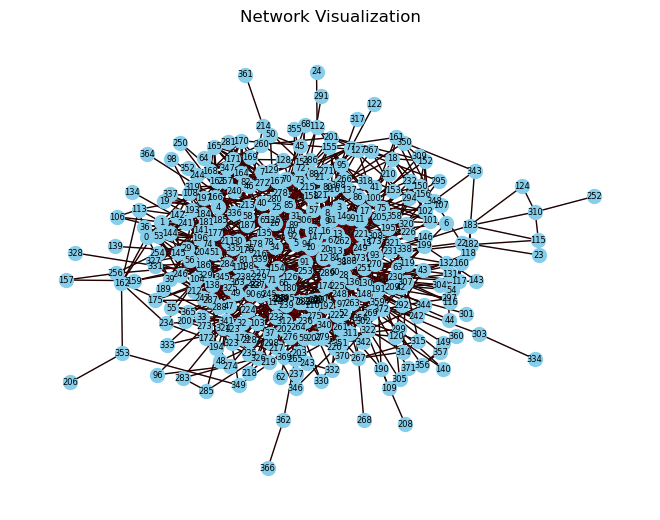

In [29]:
# Import the csv file
df = pd.read_csv('transmission_network.csv', sep=';')
df = df.rename(columns={df.columns[0]:'nodes'})

# Create graph object and add nodes to it
Graph_obj = nx.Graph()
nodes = df['nodes'].tolist()
Graph_obj.add_nodes_from(nodes)

# Add edges between nodes based on the csv-file
for _, row in df.iterrows():
    source_node = row['nodes']
    for col_name, edge_value in row.items():
        if col_name != 'nodes' and edge_value != 0:
            Graph_obj.add_edge(source_node, int(col_name))
            

# Relabel the nodes
Graph_obj = nx.convert_node_labels_to_integers(Graph_obj, first_label=0)

# create a layout for the nodes
pos = nx.kamada_kawai_layout(Graph_obj)

# draw the nodes and edges
nx.draw(Graph_obj, pos, with_labels=True, node_size=100, node_color='skyblue', font_size=6, font_color='black')
nx.draw_networkx_edges(Graph_obj, pos, edge_color='red', width=0.1)

# display the graph
plt.axis('off')
plt.title("Network Visualization")
plt.show()

In [30]:
def simulation_run(S, I, R, vacc_ix, acc_ix, run, null_strategy, SIR_model, non_vaccinated_nodes, vaccinations_per_timestep, test_accuracy, tests_left, vaccinated_nodes):
    for t in range(nr_iterations):
        iteration = SIR_model.iteration(node_status=True)
        if not null_strategy:
            # Pre-allocate useful variables
            counter = 0
            nodes_to_vaccinate = []
            
            # Re-order the list of non_vaccinated_nodes such that the nodes with the highest degrees are vaccinated first.
            node_degrees = {node: Graph_obj.degree(node) for node in non_vaccinated_nodes}
            ranked_nodes = sorted(node_degrees, key=node_degrees.get, reverse=True)
            
            # a list of nodes_to_vaccinate will be appended with nodes that have been tested as susceptible only if there are tests left.
            # So the number of executed tests is dynamic such that the number of detected susceptibles is equal to the number of vaccinations 
            # that is allowed to perform each timestep or the number of tests we can execute is 0. 
            while len(nodes_to_vaccinate) < vaccinations_per_timestep and tests_left > 0:
                p = np.random.uniform()
                
                # We don't vaccinate false negatives (so the node is actually susceptible, but is tested as something else).
                # We do add false positives (so the node is falsely tested to be susceptible) to the vaccination lists, but don't change the state.
                # If it was already recovered, it won't change. 
                # If it was infected, the vaccination won't make the node go to recovered quicker than the infected state will. 
                if p < test_accuracy and SIR_model.status[ranked_nodes[counter]] == 0:
                    nodes_to_vaccinate.append(ranked_nodes[counter])
                elif p > test_accuracy and (SIR_model.status[ranked_nodes[counter]] == 1 or SIR_model.status[ranked_nodes[counter]] == 2):
                    nodes_to_vaccinate.append(ranked_nodes[counter])
                counter += 1
                tests_left -= 1
            
            # How to deal with having no tests left
            if len(nodes_to_vaccinate) < vaccinations_per_timestep:
                diff = vaccinations_per_timestep - len(nodes_to_vaccinate)
                for i in range(diff):
                    if counter + i < len(ranked_nodes):
                        nodes_to_vaccinate.append(ranked_nodes[counter+i])

        else: 
            nodes_to_vaccinate = np.random.choice(list(non_vaccinated_nodes), min(vaccinations_per_timestep, len(non_vaccinated_nodes)), replace=False)
            

        for node in nodes_to_vaccinate:
            if SIR_model.status[node] == 1:
                vaccinated_nodes.add(node)
                non_vaccinated_nodes.remove(node)
            else: 
                SIR_model.status[node] = 2 
                vaccinated_nodes.add(node)
                non_vaccinated_nodes.remove(node)

        # Extract values based on updated structure
        node_counts = SIR_model.build_trends([iteration])[0]['trends']['node_count']
        S[acc_ix, vacc_ix, null_strategy, run, t] = node_counts[0][-1]
        I[acc_ix, vacc_ix, null_strategy, run, t] = node_counts[1][-1]
        R[acc_ix, vacc_ix, null_strategy, run, t] = node_counts[2][-1]
        
    return S, I, R

In [31]:
test_accuracies = [0.5, 0.75, 1]
vaccinations_per_timestep_Values = [1, 3, 5, 10]
null_strategies = [0, 1]
runs = 1000

# Pre-allocate variables.
S = np.zeros((len(test_accuracies), len(vaccinations_per_timestep_Values), len(null_strategies), runs, nr_iterations))
I = np.zeros((len(test_accuracies), len(vaccinations_per_timestep_Values), len(null_strategies), runs, nr_iterations))
R = np.zeros((len(test_accuracies), len(vaccinations_per_timestep_Values), len(null_strategies), runs, nr_iterations))
x = np.linspace(0, nr_iterations+1, nr_iterations)


for vacc_ix, vaccinations_per_timestep in enumerate(vaccinations_per_timestep_Values):
    for acc_ix, test_accuracy in enumerate(test_accuracies):
        for null_strategy in null_strategies:
            for run in range(runs):
                # Generate SIR model object
                SIR_model = ep.SIRModel(Graph_obj)

                # Set parameter values
                beta = 1
                gamma = 0.2
                percentage_infected = 5/374
                nr_iterations = 50
                tests_left = 200


                vaccinated_nodes = set()
                non_vaccinated_nodes = set(Graph_obj.nodes())

                # Run experiment
                cfg = mc.Configuration()
                cfg.add_model_parameter("percentage_infected", percentage_infected) 


                # (Re)set every node as susceptible
                for node in Graph_obj.nodes():
                    SIR_model.status[node] = 0
                    
                # Set model configurations
                cfg.add_model_parameter('beta', beta)
                cfg.add_model_parameter('gamma', gamma)
                SIR_model.set_initial_status(cfg)

                S, I, R = simulation_run(S, I, R, vacc_ix, acc_ix, run, null_strategy, SIR_model, non_vaccinated_nodes, vaccinations_per_timestep, test_accuracy, tests_left, vaccinated_nodes)



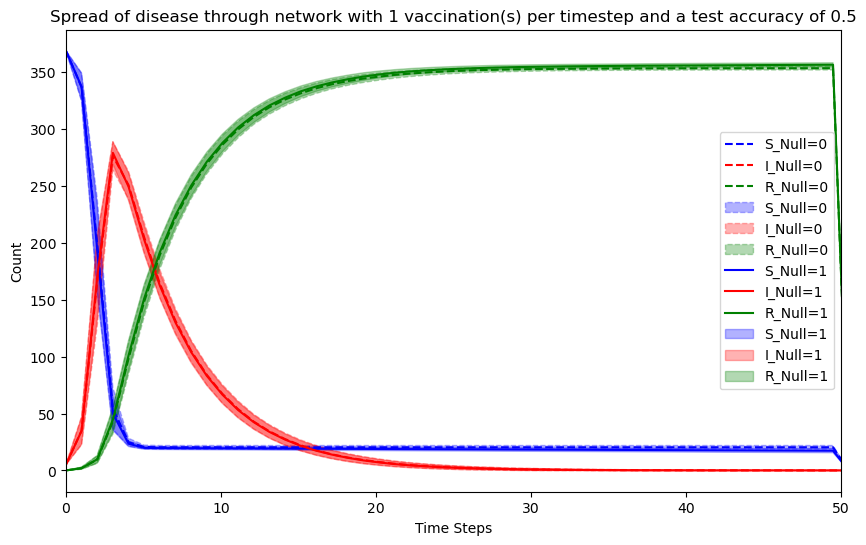

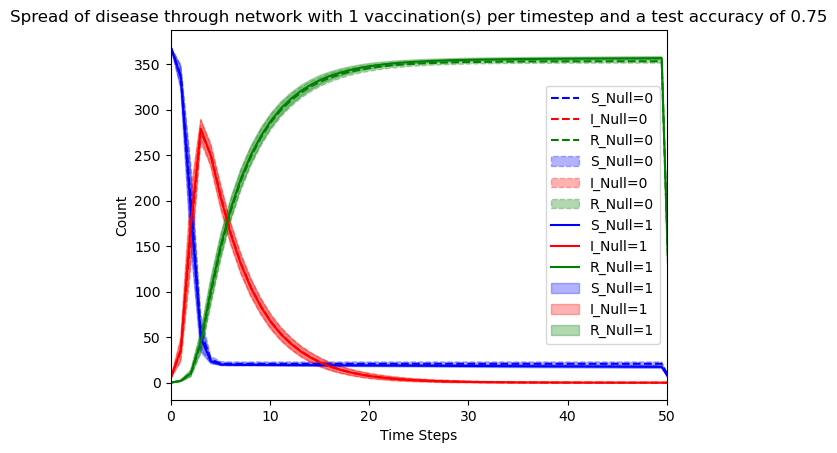

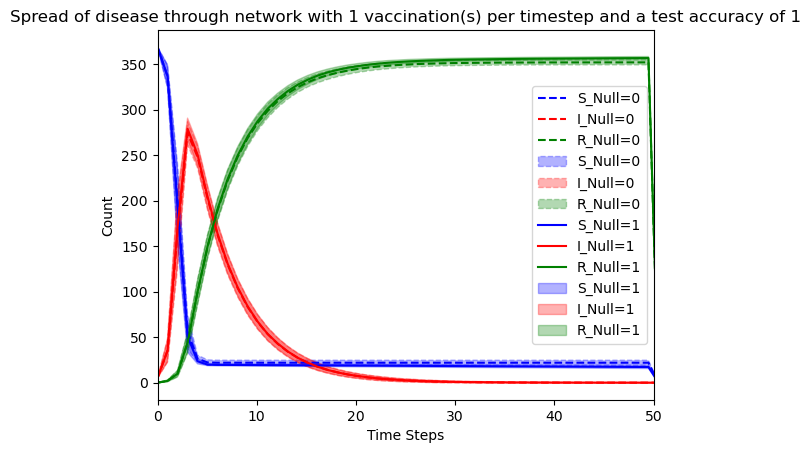

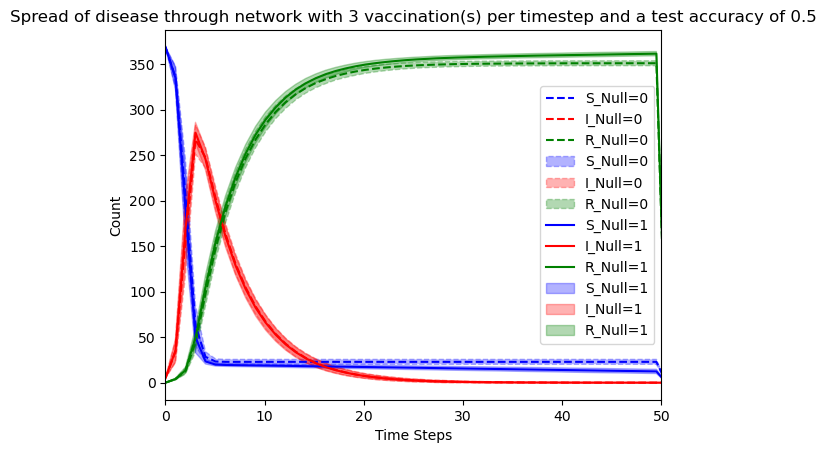

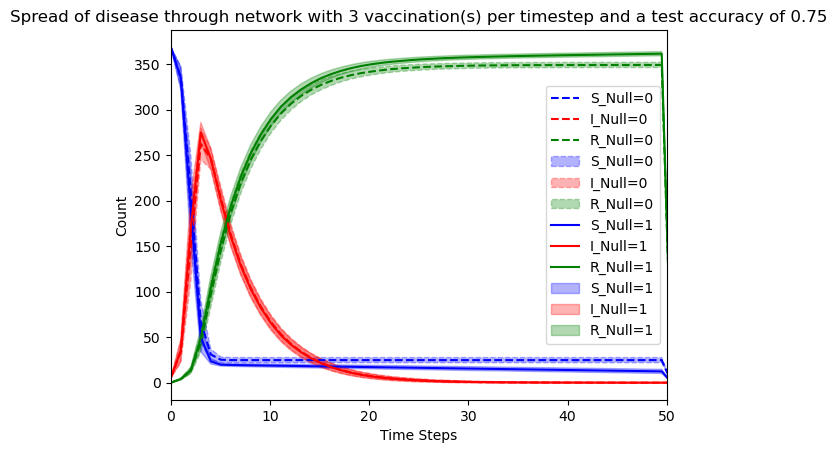

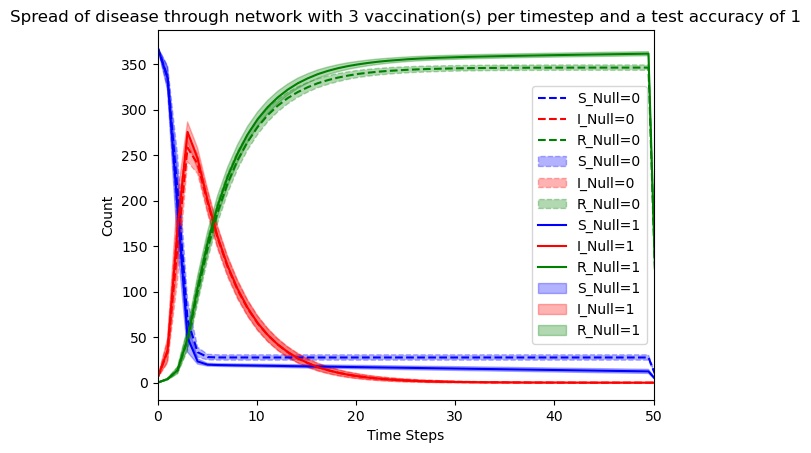

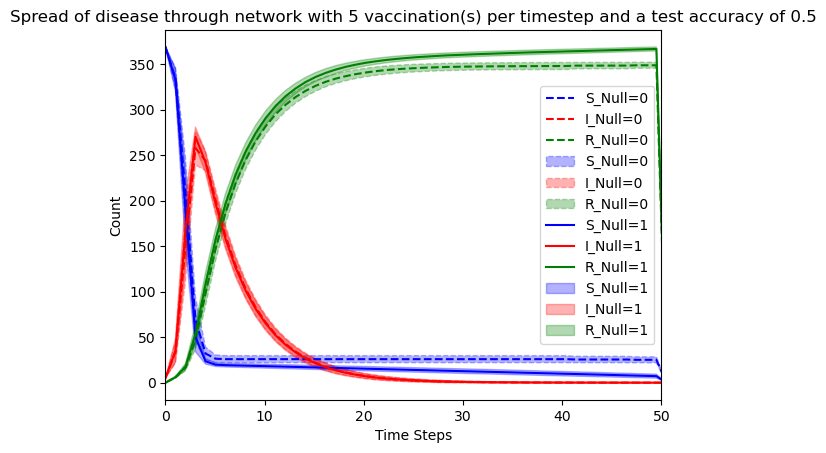

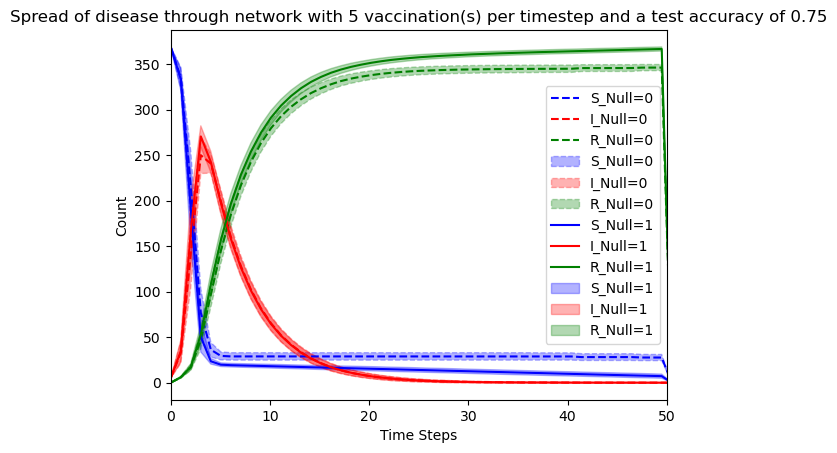

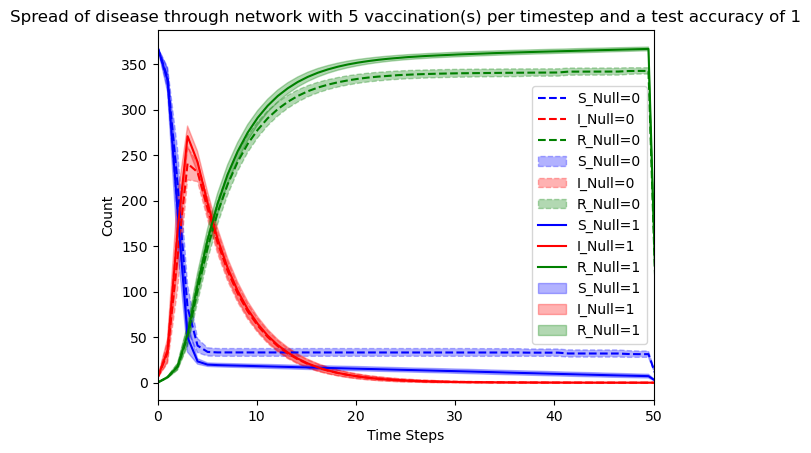

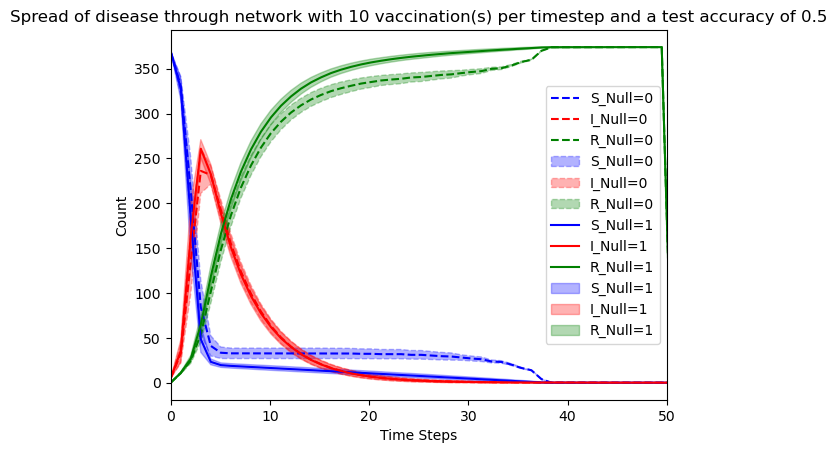

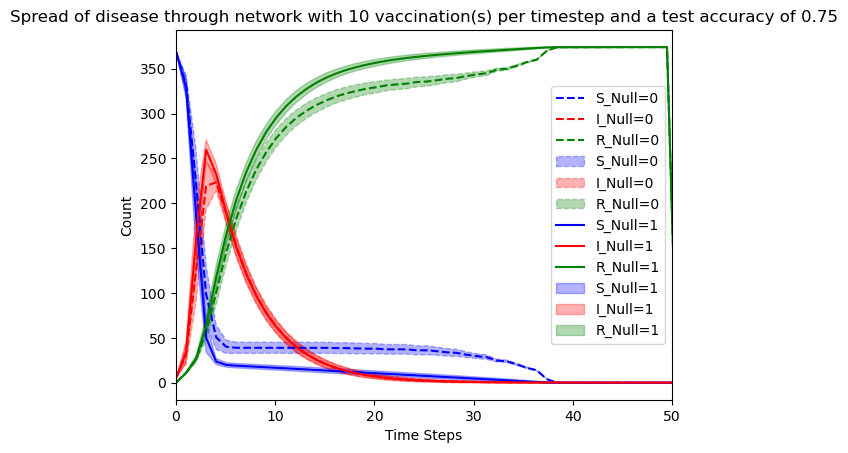

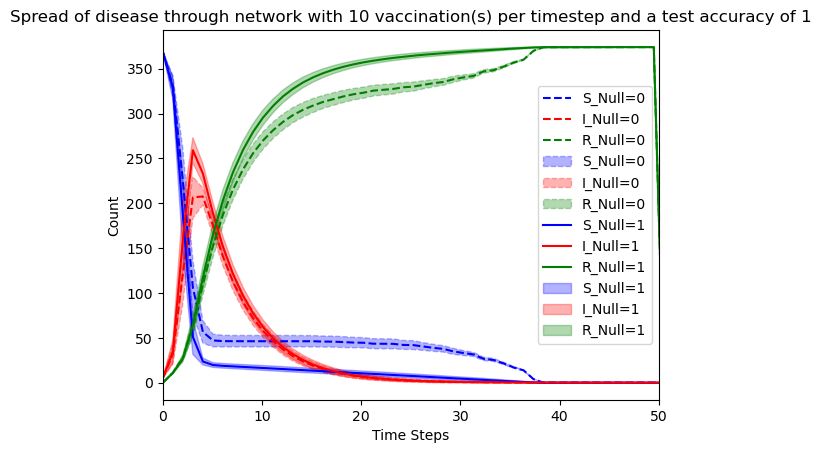

In [32]:
S_mean = np.mean(S, axis=3)
I_mean = np.mean(I, axis=3)
R_mean = np.mean(R, axis=3)
S_std = np.std(S, axis=3)
I_std = np.std(I, axis=3)
R_std = np.std(R, axis=3)

plt.figure(figsize=(10, 6))
for vacc_ix, vaccinations_per_timestep in enumerate(vaccinations_per_timestep_Values):
    for acc_ix, test_accuracy in enumerate(test_accuracies):
        for null_strategy in null_strategies:
            # Plot of average dynamics
            if null_strategy:
                linestyle='-'
            else:
                linestyle='--'
            plt.plot(x, S_mean[acc_ix, vacc_ix, null_strategy], label=f"S_Null={null_strategy}", color='blue', linestyle=linestyle)
            plt.plot(x, I_mean[acc_ix, vacc_ix, null_strategy], label=f"I_Null={null_strategy}", color='red', linestyle=linestyle)
            plt.plot(x, R_mean[acc_ix, vacc_ix, null_strategy], label=f"R_Null={null_strategy}", color='green', linestyle=linestyle)
            plt.fill_between(x, S_mean[acc_ix, vacc_ix, null_strategy]+S_std[acc_ix, vacc_ix, null_strategy], S_mean[acc_ix, vacc_ix, null_strategy]-S_std[acc_ix, vacc_ix, null_strategy], label=f"S_Null={null_strategy}", color='blue', linestyle=linestyle, alpha=0.3)
            plt.fill_between(x, I_mean[acc_ix, vacc_ix, null_strategy]+I_std[acc_ix, vacc_ix, null_strategy], I_mean[acc_ix, vacc_ix, null_strategy]-I_std[acc_ix, vacc_ix, null_strategy], label=f"I_Null={null_strategy}", color='red', linestyle=linestyle, alpha=0.3)
            plt.fill_between(x, R_mean[acc_ix, vacc_ix, null_strategy]+R_std[acc_ix, vacc_ix, null_strategy], R_mean[acc_ix, vacc_ix, null_strategy]-R_std[acc_ix, vacc_ix, null_strategy], label=f"R_Null={null_strategy}", color='green', linestyle=linestyle, alpha=0.3)
        plt.title(f'Spread of disease through network with {vaccinations_per_timestep}'
                f' vaccination(s) per timestep and a test accuracy of {test_accuracy}')
        plt.xlabel("Time Steps")
        plt.ylabel("Count")
        plt.legend()
        plt.xlim((0,50))
        plt.show()

In [54]:
I_peak = np.max(I, axis=4) #zeros((len(vaccinations_per_timestep_Values), len(test_accuracies), len(null_strategies), runs))

for vacc_ix, vaccinations_per_timestep in enumerate(vaccinations_per_timestep_Values):
    for acc_ix, test_accuracy in enumerate(test_accuracies):
        print('--------------------------------------------------')
        print(f'With #vaccinations per timestep = {vaccinations_per_timestep} and test_accuracy = {test_accuracy}')        
        stat0, p_val0 = stats.normaltest(I_peak[acc_ix, vacc_ix, 0])
        stat1, p_val1 = stats.normaltest(I_peak[acc_ix, vacc_ix, 1])
        if p_val0 > 0.05 and p_val1 > 0.05:
            stat2 = stats.ttest_rel(I_peak[acc_ix, vacc_ix, 0], I_peak[acc_ix, vacc_ix, 1])
            # Knowing what the results are by running it without the elaborate reporting of the results, 
            # we didn't type out the else statement 
            if stat2.pvalue < 0.05:
                print(f'The null strategy shows a peak of infected people (M={np.mean(I_peak[acc_ix, vacc_ix, 1])}, SE={stats.sem(I_peak[acc_ix, vacc_ix, 0])})'
                      f' that is larger than the proposed strategy (M={np.mean(I_peak[acc_ix, vacc_ix, 0])}, SE={stats.sem(I_peak[acc_ix, vacc_ix, 1])})'
                      f't({stat2.df}) = {stat2.statistic}, p < 0.05')
                effect_size = np.sqrt((stat2.statistic**2)/((stat2.statistic**2)+stat2.df))
                if effect_size > 0.5:
                    print(f'This is a large effect: r={effect_size}')
                elif effect_size > 0.3 and effect_size < 0.5:
                    print(f'This is a medium effect: r={effect_size}')
                elif effect_size > 0.1 and effect_size < 0.3:
                    print(f'This is a small effect: r={effect_size}')
            else:
                print('not significant')
        else:
            stat2 = stats.wilcoxon(I_peak[acc_ix, vacc_ix, 0], I_peak[acc_ix, vacc_ix, 1])
            # Knowing what the results are by running it without the elaborate reporting of the results, 
            # we didn't type out the else statement 
            if stat2.pvalue < 0.05:
                print(f'The null strategy shows a peak of infected people (Median={int(np.median(I_peak[acc_ix, vacc_ix, 1]))})'
                      f' that is larger than the proposed strategy (Median={int(np.median(I_peak[acc_ix, vacc_ix, 0]))})'
                      f'Z = {stat2.statistic}, p < 0.05')
                effect_size = stat2.statistic/(np.sqrt(runs))
                if effect_size > 0.5:
                    print(f'This is a large effect: r={effect_size}')
                elif effect_size > 0.3 and effect_size < 0.5:
                    print(f'This is a medium effect: r={effect_size}')
                elif effect_size > 0.1 and effect_size < 0.3:
                    print(f'This is a small effect: r={effect_size}')
            else:
                print('not significant')


--------------------------------------------------
With #vaccinations per timestep = 1 and test_accuracy = 0.5
--------------------------------------------------
With #vaccinations per timestep = 1 and test_accuracy = 0.75
--------------------------------------------------
With #vaccinations per timestep = 1 and test_accuracy = 1
--------------------------------------------------
With #vaccinations per timestep = 3 and test_accuracy = 0.5
--------------------------------------------------
With #vaccinations per timestep = 3 and test_accuracy = 0.75
--------------------------------------------------
With #vaccinations per timestep = 3 and test_accuracy = 1
--------------------------------------------------
With #vaccinations per timestep = 5 and test_accuracy = 0.5
--------------------------------------------------
With #vaccinations per timestep = 5 and test_accuracy = 0.75
--------------------------------------------------
With #vaccinations per timestep = 5 and test_accuracy = 1
The 